# Struttura dei test

Di seguito un'analisi comparativa sul modulo implementato (PPGA) in cui si va
a confrontare

- Versioni sequenziale e parallela di PPGA.
- Versioni sequenziale e parallela di DEAP.
- PPGA e DEAP nelle loro versioni sequenziale e parallela.

I benchmark sono stati effettuati su una macchina con doppio processore AMD
EPYC 7313, ciascuno dei quali con 16 core fisici con frequenza di clock massima
a 3.7 GHz. Il problema di riferimento è quello di explainability in cui è stato
eseguito l'algoritmo genetico su un solo punto del dataset (32 feature) e su
una sola classe target. I parametri variabili presi in considerazione sono:

- **Modello predittivo**: RandomForestClassifier, SVC e MLPClassifier.
- **Numero di individui sintetici**: 1000, 2000, 4000, 8000, 16000.
- **Numero di worker**: 1, 2, 4, 8, 16, 32. Le esecuzioni con 1 worker
  corrispondono in realtà alla versione sequenziale dell'algoritmo.

Sono state esplorate tutte le possibili combinazioni di tali parametri e, per
ciascuna di esse sono stati eseguiti 10 test compiendo 5 iterazioni
dell'algoritmo. I risultati dei 10 test sono stati poi aggregati prendendo
media e deviazione standard dei tempi registrati.

Un'ulteriore precisazione riguarda l'utilizzo della _Hall of Fame_: in entrambi
i casi viene usata una hall of fame ma per PPGA questa ha una dimensione pari
a quella della popolazione iniziale, mentre per DEAP può contenere solo il
10% del numero di individui della popolazione iniziale. Questa precisazione
nasce dai risultati ottenuti in altri test, in cui è emerso come per DEAP,
l'utilizzo e la dimensione della Hall of Fame intacchino particolarmente le
performance.

Per entrambe le librerie sono stati misurati sia il tempo complessivo impiegato
sia il solo tempo necessario alle fasi parallelizzate. Nel caso di PPGA queste
fasi sono quelle di crossover, mutazione e valutazione, mentre DEAP dà la
possibilità di eseguire solo la fase di valutazione in parallelo.

# PPGA

Per prima cosa si è messa a confronto la versione sequenziale e quella
parallela di PPGA, aumentando gradualmente numero di worker e dimensione della
popolazione sintetica generata.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

matplotlib.rcParams.update({"font.size": 16})

# ppga_df = pd.read_csv("../results/performance/ppga32_bm.csv")
rf = pd.read_csv("../results/performance/ppga_RandomForestClassifier_pop_final3.csv")
mlp = pd.read_csv("../results/performance/ppga_MLPClassifier_pop_final3.csv")
svm = pd.read_csv("../results/performance/ppga_SVC_pop_final3.csv")

ppga_df = pd.concat([rf, mlp, svm], axis=0)
ppga_df = (
    ppga_df.groupby(by=["classifier", "population_size", "workers"])
    .mean()[["time", "ptime"]]
    .reset_index()
)

ppga_df

classifier  population_size  workers       time     ptime
0   MLPClassifier             1000        1   3.276289   1.51666
1   MLPClassifier             1000        2   1.388282   0.87000
2   MLPClassifier             1000        4   0.855976   0.45250
3   MLPClassifier             1000        8   0.892651   0.35250
4   MLPClassifier             1000       16   1.119797   0.36500
..            ...              ...      ...        ...       ...
85            SVC            16000        2  27.793731  22.10000
86            SVC            16000        4  17.904491  11.63250
87            SVC            16000        8  12.419058   6.08500
88            SVC            16000       16  10.229195   3.99500
89            SVC            16000       32  10.019566   2.48750

[90 rows x 5 columns]

## Tempo d'esecuzione

Il dataframe contiene una colonna `time` e una colonna `ptime`. La prima indica
il tempo d'esecuzione totale, la seconda il tempo di esecuzione delle sole fasi
eseguite in parallelo.

Di seguito alcuni grafici che riportano l'andamento del tempo d'esecuzione in
funzione del diverso numero di worker e su diverse dimensioni dell'input, per
ciascun modello.


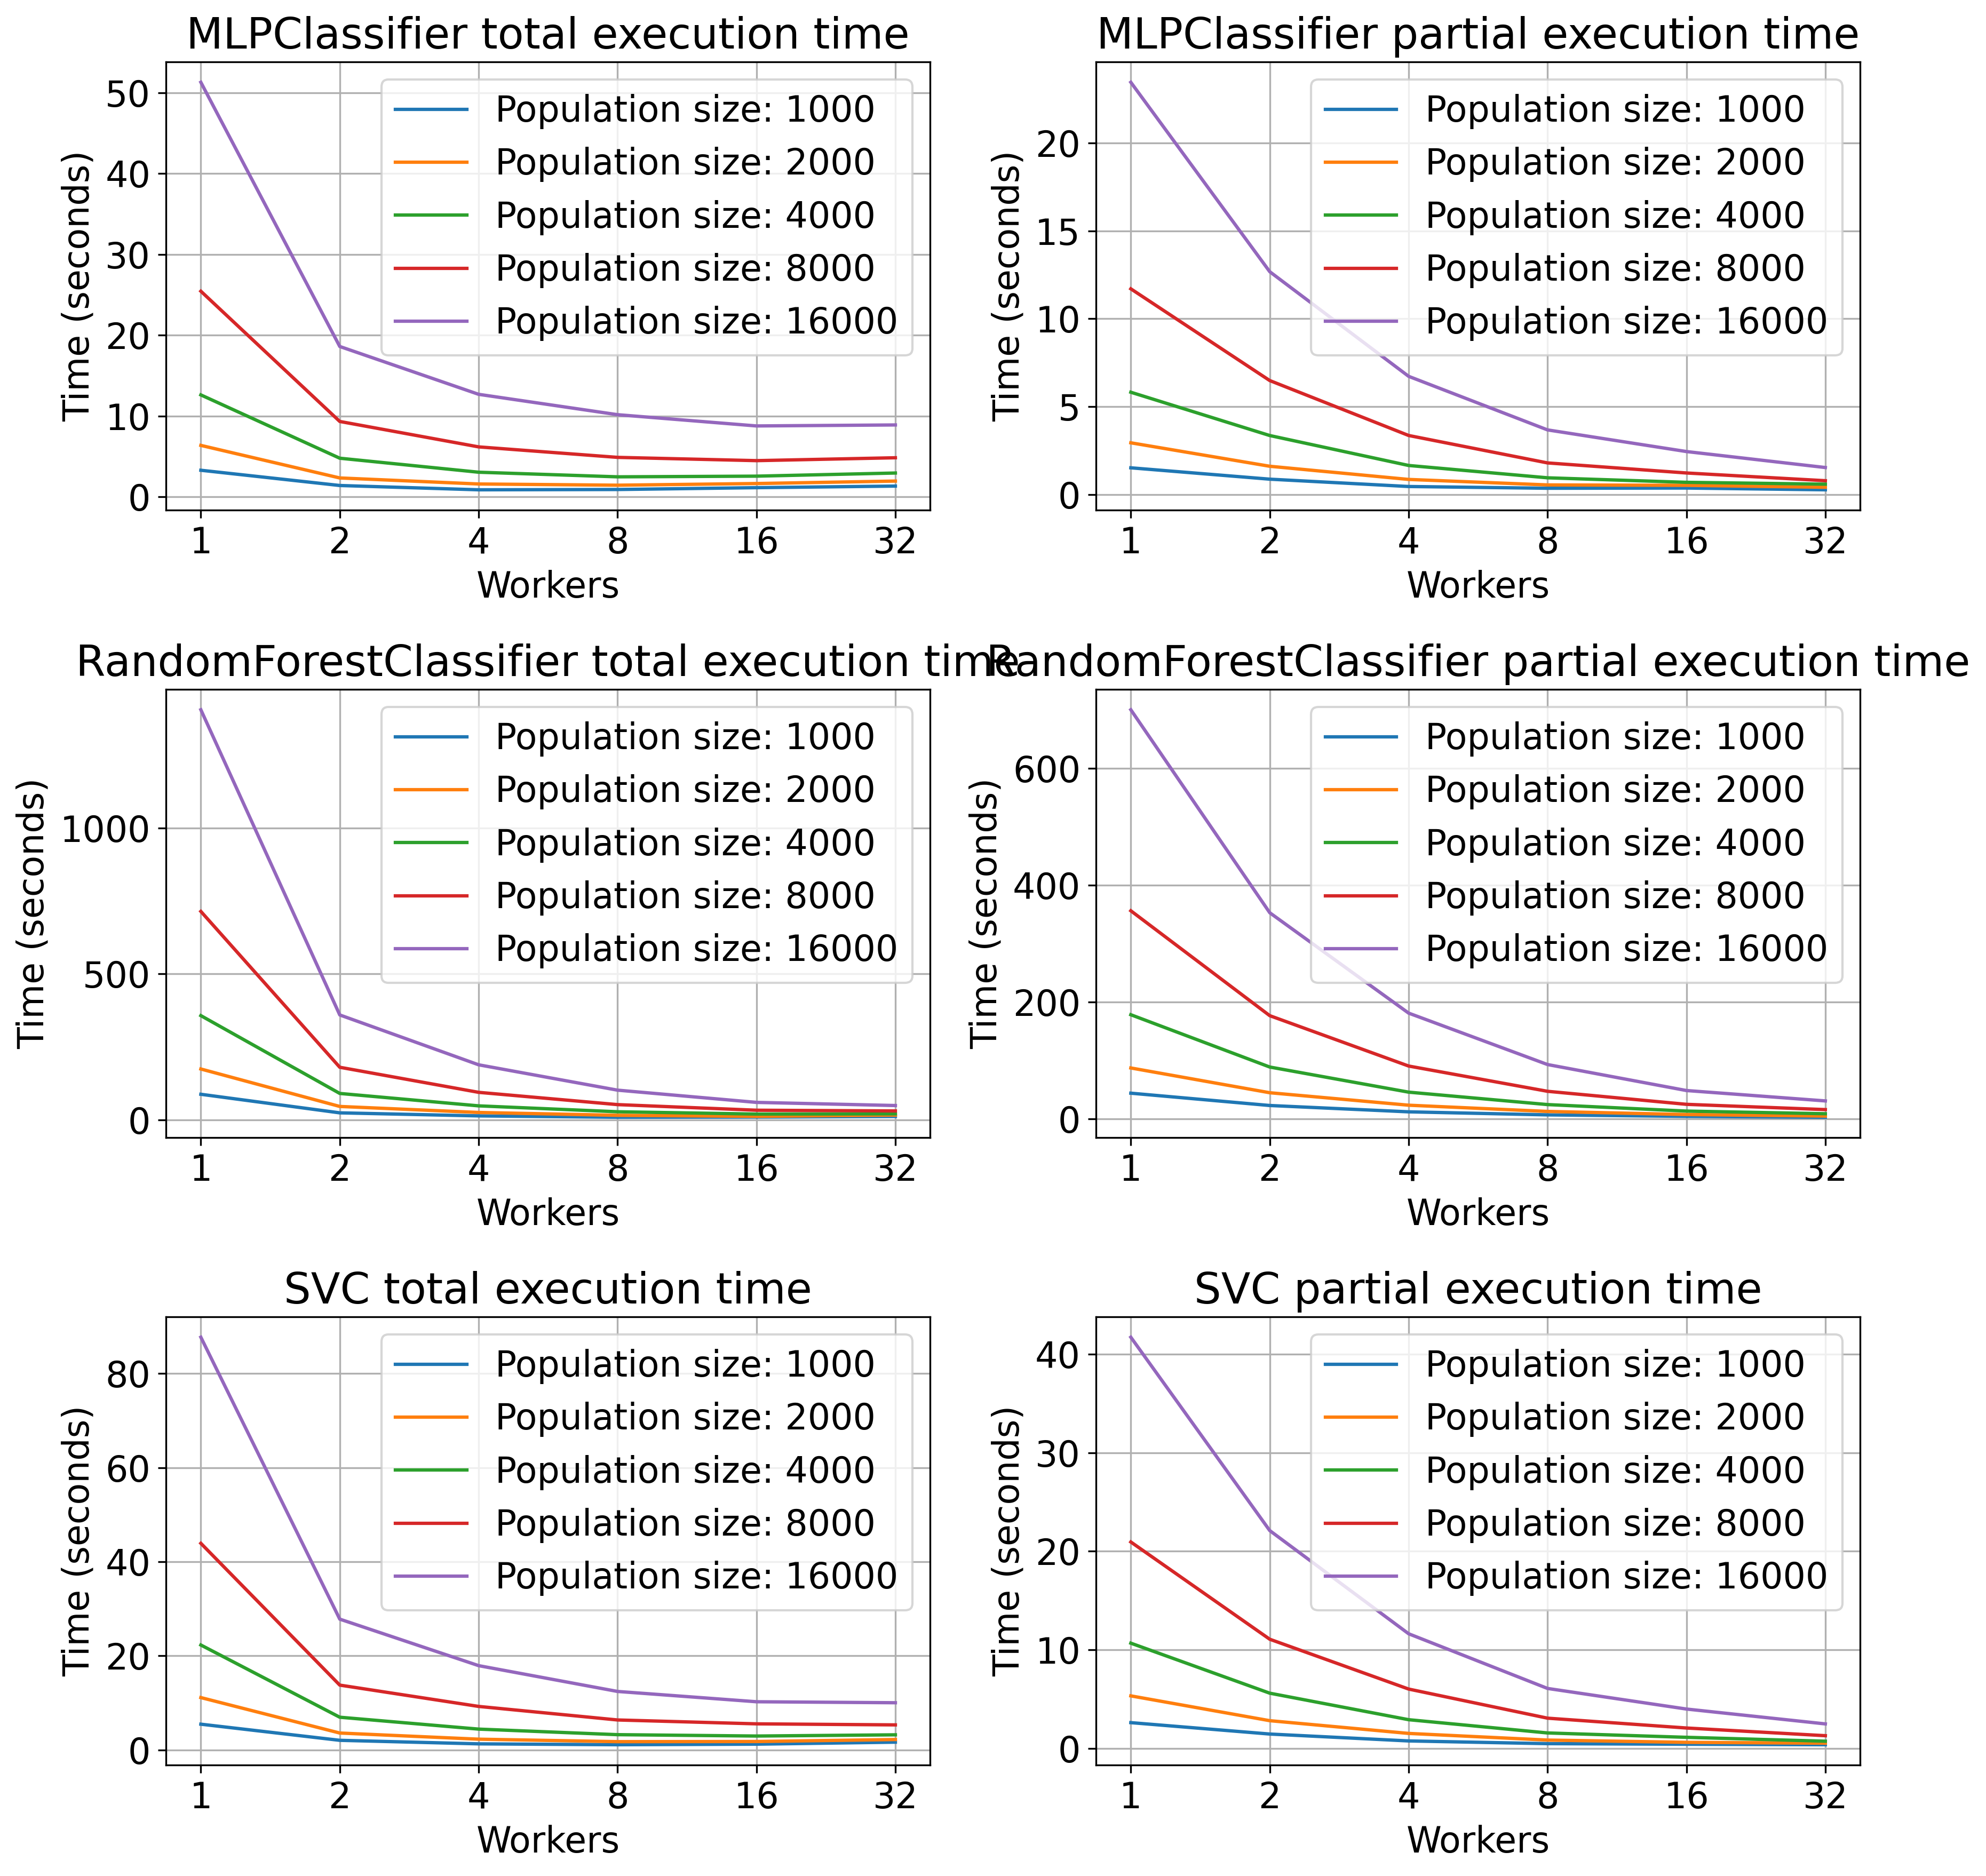

In [2]:
def plot_time(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=300)

    for i, model in enumerate(models):
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i][0].set_title(f"{model} total execution time")
            axes[i][0].set_xlabel("Workers")
            axes[i][0].set_ylabel("Time (seconds)")
            axes[i][0].plot(
                workers,
                df[mask]["time"].values,
                label=f"Population size: {ps}",
            )

            axes[i][0].set_xscale("log", base=2)
            axes[i][0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i][0].grid()
            axes[i][0].legend()

            axes[i][1].set_title(f"{model} partial execution time")
            axes[i][1].set_xlabel("Workers")
            axes[i][1].set_ylabel("Time (seconds)")
            axes[i][1].plot(
                workers,
                df[mask]["ptime"].values,
                label=f"Population size: {ps}",
            )

            axes[i][1].set_xscale("log", base=2)
            axes[i][1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i][1].grid()
            axes[i][1].legend()

    plt.tight_layout()
    plt.show()


plot_time(ppga_df)

### Tempo fase parallela

Sono state inoltre a confrontare le colonne `time` e `ptime` per capire quanto
tempo viene speso nella fase parallela in confronto al resto dell'algoritmo.
In questo modo si ha un'idea migliore di come e quanto l'impiega di un modello
di calcolo parallelo possa influenzare il tempo complessivo dell'algoritmo.


In [26]:
ppga_ptime_perc = (
    ppga_df.groupby(["classifier", "population_size"])
    .mean()[["time", "ptime"]]
    .reset_index()
)

ppga_ptime_perc["ptime_perc"] = (
    ppga_ptime_perc["ptime"] / ppga_ptime_perc["time"] * 100.0
)

ppga_ptime_perc.groupby(by=["classifier"]).mean()["ptime_perc"]

classifier
MLPClassifier             45.213908
RandomForestClassifier    62.562697
SVC                       51.603042
Name: ptime_perc, dtype: float64

## Speed up

Come seconda analisi è stato calcolato lo _speed up_ ottenuto per ogni
classificatore, impiegando un diverso numero di worker su popolazioni sintetiche
di dimensione crescente. Anche qui viene calcolato sia lo speed up ottenuto
sull'esecuzione dell'intero algoritmo, sia quello ottenuto sulla sola parte
parallelizzata.

Vengono quindi aggiunte due colonne al dataframe: `speed_up` e `pure_speed_up`.
La prima è calcolata tramite il rapporto tra il tempo totale dell'algoritmo
sequenziale e il tempo totale di quello parallelo. La seconda viene calcolata
in modo del tutto analogo considerando solo il tempo delle fasi eseguite in
parallelo.


In [4]:
reference_times = ppga_df[ppga_df["workers"] == 1].set_index(
    ["classifier", "population_size"]
)["time"]

ppga_df["speed_up"] = ppga_df.apply(
    lambda row: reference_times.loc[(row["classifier"], row["population_size"])]
    / row["time"],
    axis=1,
)

reference_ptimes = ppga_df[ppga_df["workers"] == 1].set_index(
    ["classifier", "population_size"]
)["ptime"]

ppga_df["pure_speed_up"] = ppga_df.apply(
    lambda row: reference_ptimes.loc[(row["classifier"], row["population_size"])]
    / row["ptime"],
    axis=1,
)

ppga_df

classifier  population_size  workers       time     ptime  speed_up  \
0   MLPClassifier             1000        1   3.276289   1.51666  1.000000   
1   MLPClassifier             1000        2   1.388282   0.87000  2.359960   
2   MLPClassifier             1000        4   0.855976   0.45250  3.827547   
3   MLPClassifier             1000        8   0.892651   0.35250  3.670291   
4   MLPClassifier             1000       16   1.119797   0.36500  2.925789   
..            ...              ...      ...        ...       ...       ...   
85            SVC            16000        2  27.793731  22.10000  3.156276   
86            SVC            16000        4  17.904491  11.63250  4.899591   
87            SVC            16000        8  12.419058   6.08500  7.063715   
88            SVC            16000       16  10.229195   3.99500  8.575913   
89            SVC            16000       32  10.019566   2.48750  8.755337   

    pure_speed_up  
0        1.000000  
1        1.743287  
2        3.351734  
3        4.302580  
4        4.155232  
..            ...  
85       1.887514  
86       3.585992  
87       6.855226  
88      10.441565  
89      16.769467  

[90 rows x 7 columns]

Di seguito vari grafici per vedere l'andamento dello speed up in relazione
al numero di individui sintetici generati. Sulla sinistra lo speed up ottenuto
sull'intero algoritmo, mentre sulla destra lo speed up ottenuto sulla sola
parte parallelizzata.

Nella colonna a destra, viene inoltre tracciata la linea (tratteggiata verde)
che definisce lo speed up ideale. Dato che si considera solo la parte
parallelizzata, lo speed up "ideale" dovrebbe essere lineare. Ci aspettiamo
quindi un valore di speed up di $k$ se impieghiamo $k$ worker per il lavoro.

Come è facile notare, il Random Forest, che è anche il più lento, è quello che
trae più beneficio da una parallelizzazione più pesante. Gli altri modelli
sono molto più performanti in fase di predizione ed è quindi più difficile
ottenere un valore di speed up vicino al numero di worker utilizzati,
soprattutto quando ne vengono impiegati molti.


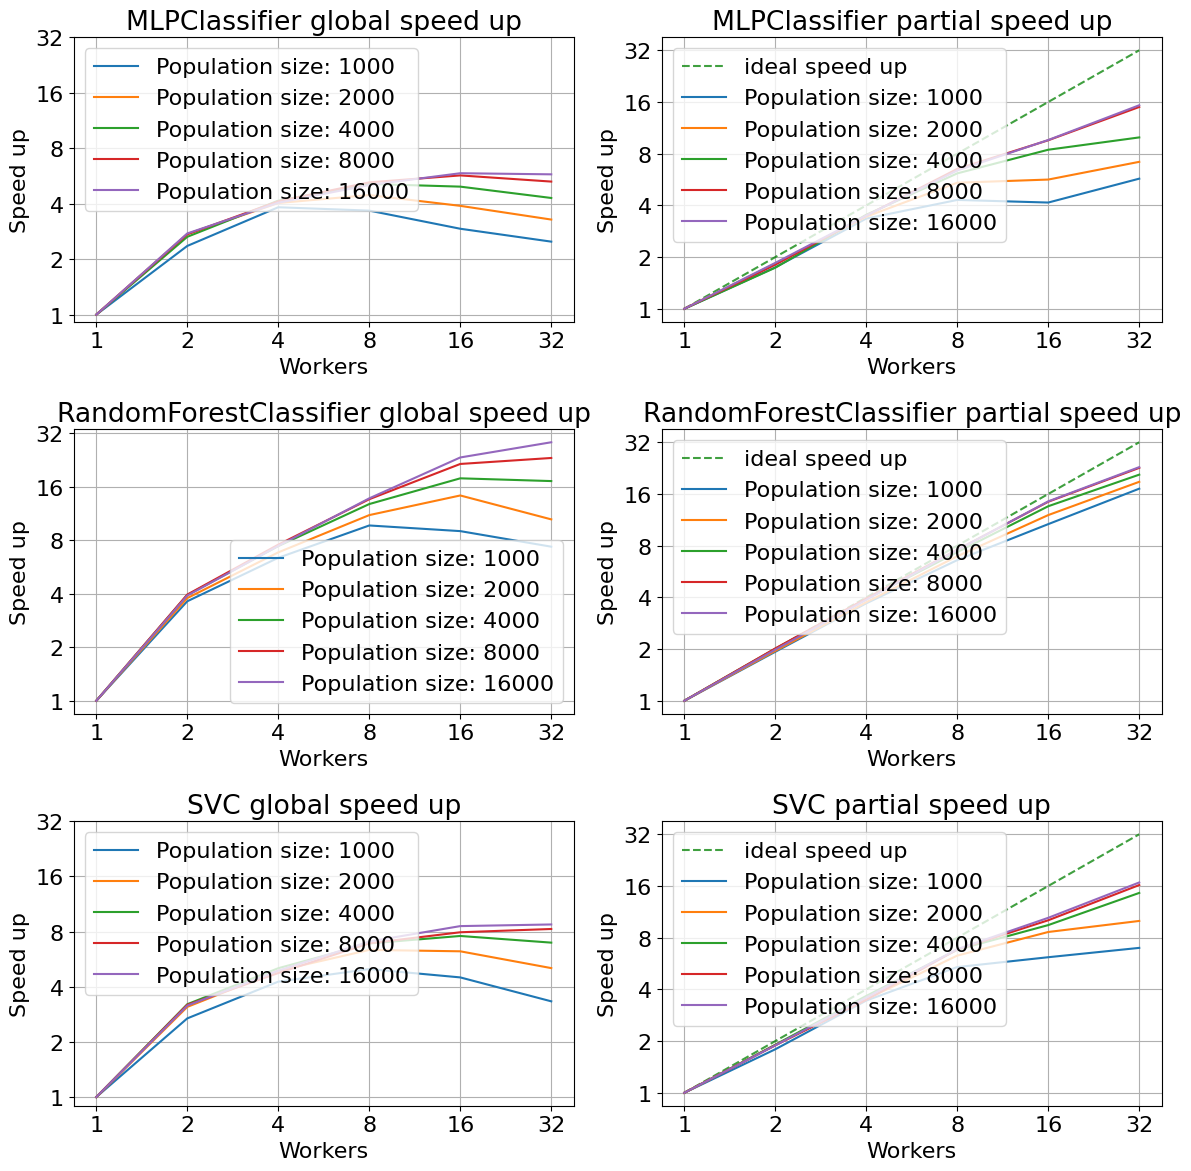

In [5]:
def plot_speed_up(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))

    for i, model in enumerate(models):
        axes[i][1].plot(workers, workers, "g--", alpha=0.75, label="ideal speed up")
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i][0].set_title(f"{model} global speed up")
            axes[i][0].set_xlabel("Workers")
            axes[i][0].set_ylabel("Speed up")
            axes[i][0].errorbar(
                workers,
                df[mask]["speed_up"].values,
                label=f"Population size: {ps}",
            )

            axes[i][0].set_xscale("log", base=2)
            axes[i][0].set_yscale("log", base=2)
            axes[i][0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i][0].set_yticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i][0].grid()
            axes[i][0].legend()

            axes[i][1].set_title(f"{model} partial speed up")
            axes[i][1].set_xlabel("Workers")
            axes[i][1].set_ylabel("Speed up")
            axes[i][1].errorbar(
                workers,
                df[mask]["pure_speed_up"].values,
                label=f"Population size: {ps}",
            )

            axes[i][1].set_xscale("log", base=2)
            axes[i][1].set_yscale("log", base=2)
            axes[i][1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i][1].set_yticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i][1].grid()
            axes[i][1].legend()

    plt.tight_layout()
    plt.show()


plot_speed_up(ppga_df)

## Stabilità

Come ultima analisi è stata valutata la stabilità delle performance
dell'algoritmo stesso andando a calcolare il coefficiente di variazione del
tempo impiegato. Tale coefficiente è stato ottenuto tramite il rapporto tra la
deviazione standard e la media del tempo impiegato.


In [6]:
# ppga_df["var_coeff"] = ppga_df["time_std"] / ppga_df["time"]
# ppga_df

In questo modo è possibile vedere la stabilità dell'algoritmo al variare di
parametri come numero di worker e dimensione della popolazione.

Come soglia per separare i test più _stabili_ dagli altri è stata impostata una
soglia del 10% per il coefficiente di variabilità.


In [7]:
# def plot_var_coeff(df: pd.DataFrame):
#     models = df["classifier"].unique()
#     workers = np.log2(np.array(df["workers"].unique()))
#     population_sizes = df["population_size"].unique()

#     fig, axes = plt.subplots(3, 1, figsize=(12, 16))

#     for model, ax in zip(models, axes):
#         ax.plot([-0.5, 5.5], [0.1, 0.1], c="r", label="low variability threshold")
#         for i, ps in enumerate(population_sizes):
#             mask = (df["classifier"] == model) & (df["population_size"] == ps)
#             ax.set_title(f"{model} execution time variability")
#             ax.set_xlabel("Workers")
#             ax.set_ylabel("Variability coefficient")
#             ax.bar(
#                 workers + i * 0.105,
#                 df[mask]["var_coeff"].values,
#                 width=0.1,
#                 label=f"Population size: {ps}",
#             )

#             ax.set_xticks(workers, labels=[int(2**w) for w in workers])
#             ax.grid()
#             ax.legend()

#     plt.tight_layout()
#     plt.show()


# plot_var_coeff(ppga_df)

# DEAP

Il modulo DEAP offre due metodi per sfruttare il parallelismo. Il primo tramite
il modulo `multiprocessing` e il secondo tramite `scoop`. Di seguito un'analisi
della versione con `multiprocessing`. Le analisi sono perfettamente analoghe
alle precedenti.


In [8]:
# deap_df = pd.read_csv("../results/performance/deap32_bm_old.csv")
mlp = pd.read_csv("../results/performance/deap_MLPClassifier_pop_final3.csv")
svm = pd.read_csv("../results/performance/deap_SVC_pop_final3.csv")
rf = pd.read_csv("../results/performance/deap_RandomForestClassifier_pop_final2.csv")

deap_df = pd.concat([mlp, svm, rf], axis=0)
deap_df = (
    deap_df.groupby(by=["classifier", "population_size", "workers"])
    .mean()[["time", "ptime"]]
    .sort_values(by=["classifier", "population_size", "workers"])
    .reset_index()
)
deap_df

classifier  population_size  workers        time      ptime
0   MLPClassifier             1000        1    5.838197   1.650671
1   MLPClassifier             1000        2    4.735578   1.002500
2   MLPClassifier             1000        4    4.719870   0.797500
3   MLPClassifier             1000        8    4.830379   0.522500
4   MLPClassifier             1000       16    4.996124   0.405000
..            ...              ...      ...         ...        ...
85            SVC            16000        2  313.098080  25.677500
86            SVC            16000        4  298.354721  13.822500
87            SVC            16000        8  291.640669   7.605000
88            SVC            16000       16  290.412387   4.720000
89            SVC            16000       32  317.282624   2.852500

[90 rows x 5 columns]

## Tempo d'esecuzione

Di seguito sono riportati i grafici dell'andamento del tempo d'esecuzione al
variare del numero di worker.


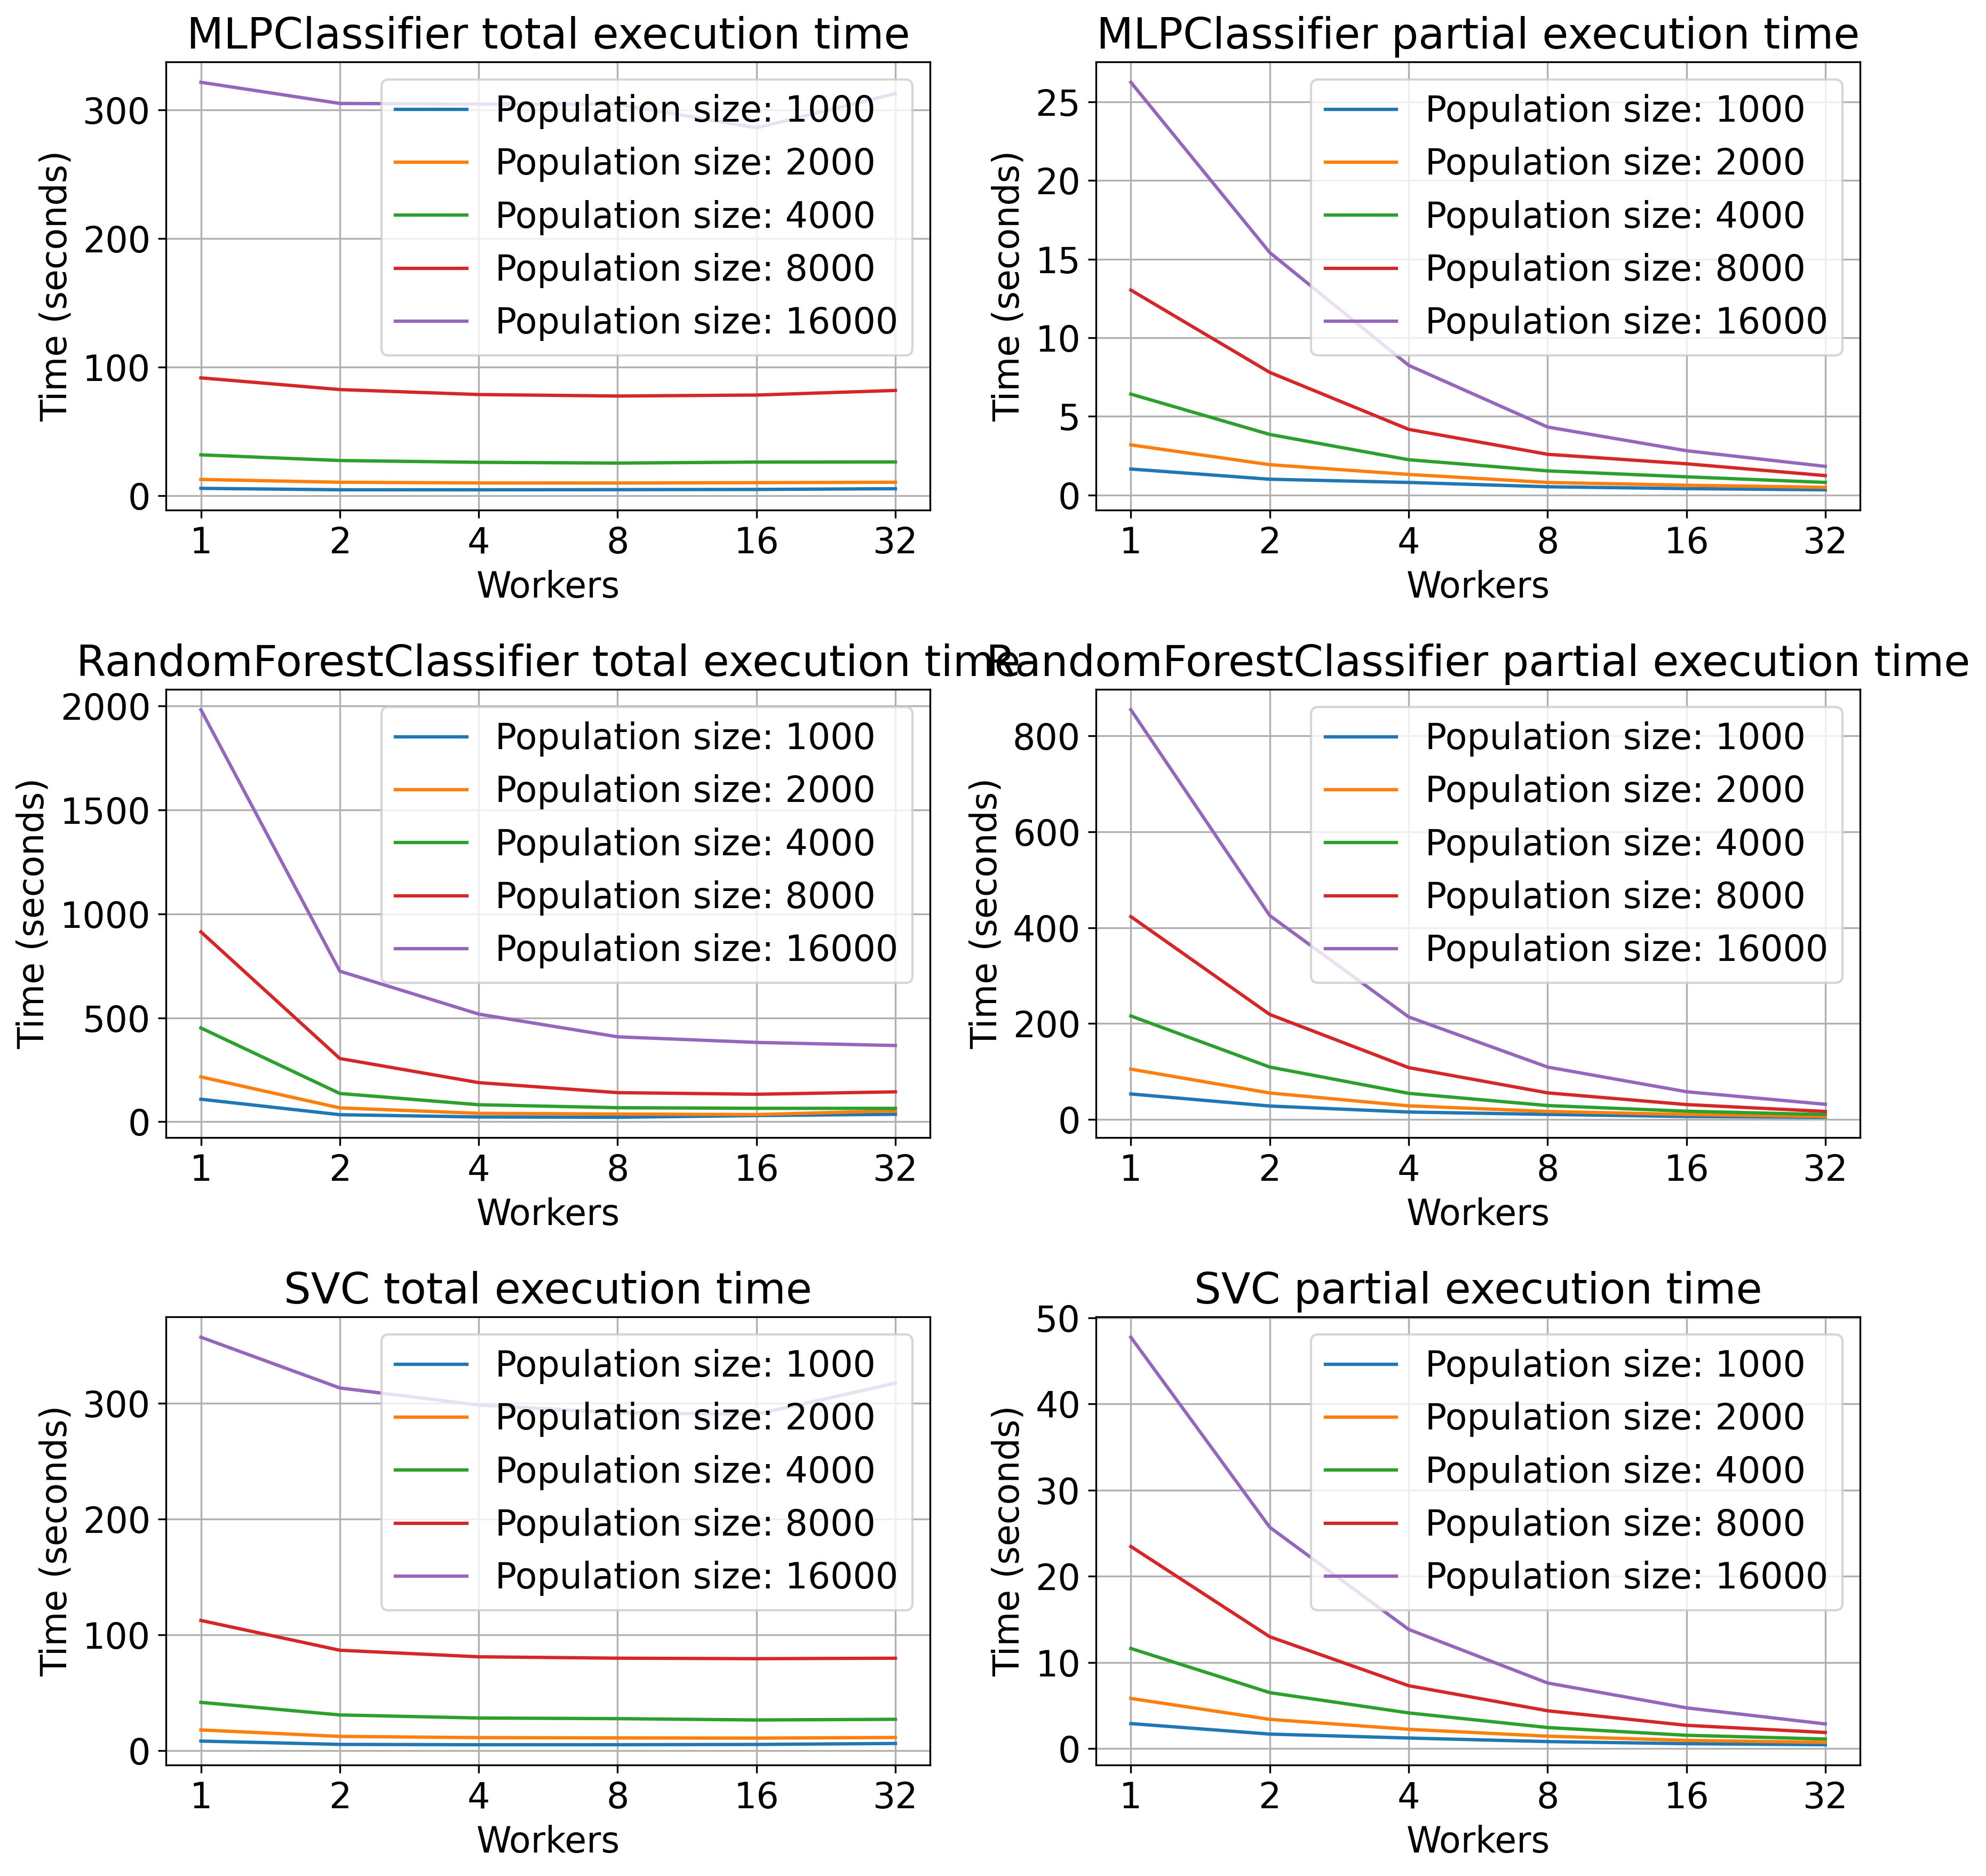

In [9]:
plot_time(deap_df)

### Tempo fase parallela

Come per PPGA è stato calcolato il tempo medio speso nella fase parallelizzata.


In [27]:
deap_ptime_perc = (
    deap_df.groupby(["classifier", "population_size"])
    .mean()[["time", "ptime"]]
    .reset_index()
)

deap_ptime_perc["ptime_perc"] = (
    deap_ptime_perc["ptime"] / deap_ptime_perc["time"] * 100.0
)

deap_ptime_perc.groupby(by=["classifier"]).mean()["ptime_perc"]

classifier
MLPClassifier              9.516229
RandomForestClassifier    46.287445
SVC                       14.294032
Name: ptime_perc, dtype: float64

## Speed up

Come prima è stato calcolato e analizzato lo speed up ottenuto (sia globale
che parziale).


In [11]:
reference_times = deap_df[deap_df["workers"] == 1].set_index(
    ["classifier", "population_size"]
)["time"]

deap_df["speed_up"] = deap_df.apply(
    lambda row: reference_times.loc[(row["classifier"], row["population_size"])]
    / row["time"],
    axis=1,
)

reference_ptimes = deap_df[deap_df["workers"] == 1].set_index(
    ["classifier", "population_size"]
)["ptime"]

deap_df["pure_speed_up"] = deap_df.apply(
    lambda row: reference_ptimes.loc[(row["classifier"], row["population_size"])]
    / row["ptime"],
    axis=1,
)

deap_df

classifier  population_size  workers        time      ptime  speed_up  \
0   MLPClassifier             1000        1    5.838197   1.650671  1.000000   
1   MLPClassifier             1000        2    4.735578   1.002500  1.232837   
2   MLPClassifier             1000        4    4.719870   0.797500  1.236940   
3   MLPClassifier             1000        8    4.830379   0.522500  1.208642   
4   MLPClassifier             1000       16    4.996124   0.405000  1.168545   
..            ...              ...      ...         ...        ...       ...   
85            SVC            16000        2  313.098080  25.677500  1.139958   
86            SVC            16000        4  298.354721  13.822500  1.196290   
87            SVC            16000        8  291.640669   7.605000  1.223831   
88            SVC            16000       16  290.412387   4.720000  1.229007   
89            SVC            16000       32  317.282624   2.852500  1.124924   

    pure_speed_up  
0        1.000000  
1        1.646555  
2        2.069807  
3        3.159179  
4        4.075731  
..            ...  
85       1.858804  
86       3.453026  
87       6.276061  
88      10.112171  
89      16.732497  

[90 rows x 7 columns]

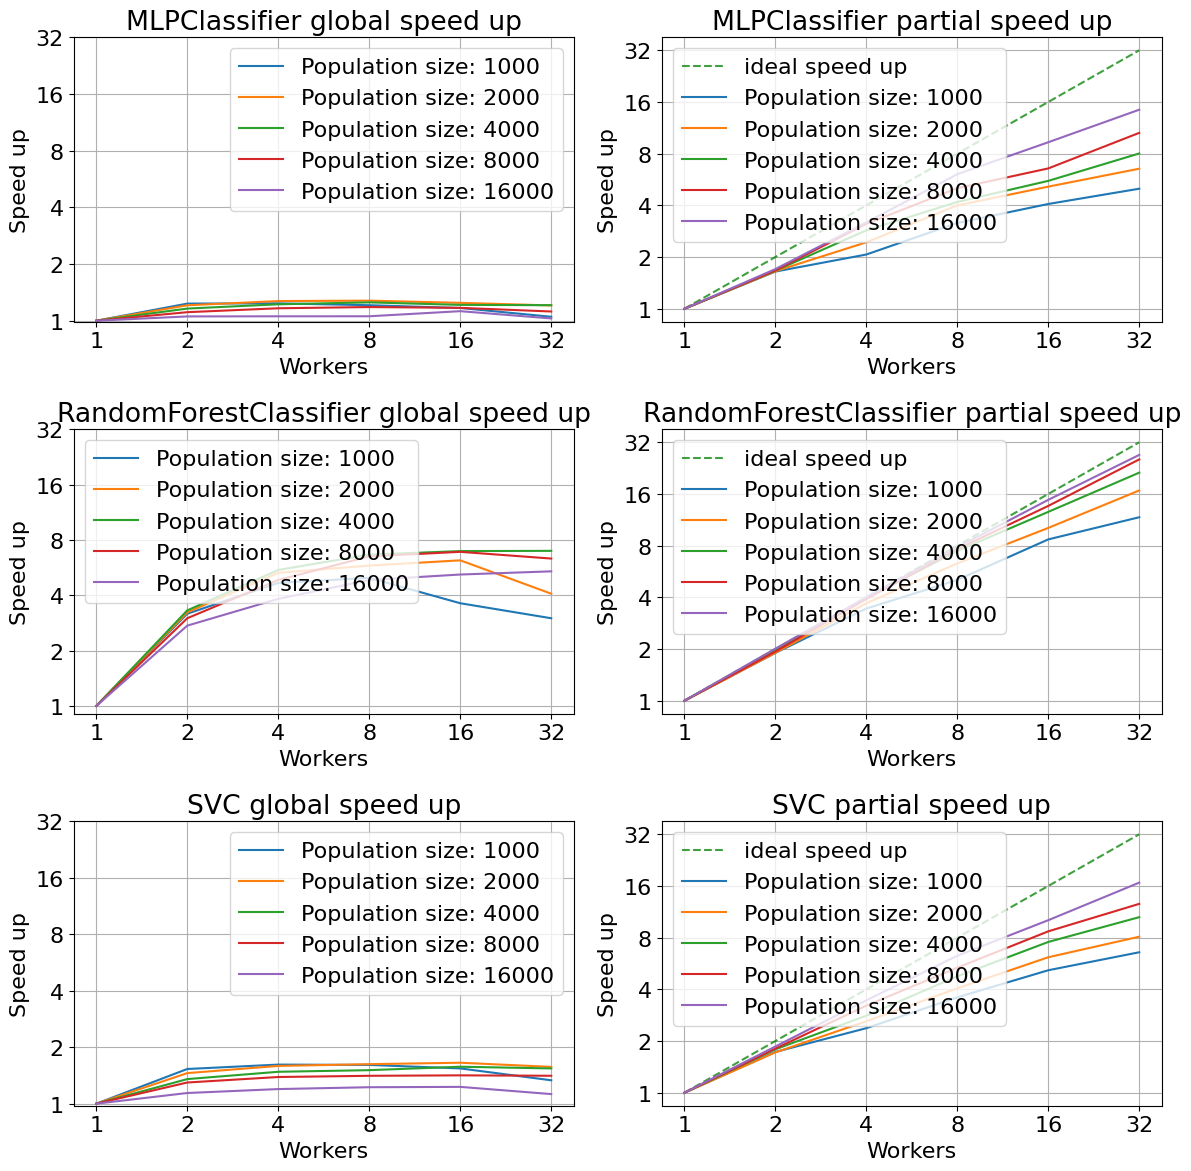

In [12]:
plot_speed_up(deap_df)

# Confronto

Il confronto tra le due librerie è avvenuto comparando tra loro tre parametri
chiave:

- Tempo d'esecuzione
- Speed up
- Coefficiente di speed up

L'ultimo è un parametro che ci permette di paragonare lo speed up in modo
proporzionale tra i due algoritmi che possono aver ottenuto tempi d'esecuzione
differenti.

## Tempo d'esecuzione

Il primo confronto è stato fatto sul tempo d'esecuzione totale dei due
algoritmi.


In [13]:
time_cmp = pd.DataFrame(
    {
        "classifier": ppga_df["classifier"].values,
        "population_size": ppga_df["population_size"].values,
        "workers": ppga_df["workers"].values,
        "ppga": ppga_df["time"].values,
        "p_ppga": ppga_df["ptime"].values,
        "deap": deap_df["time"].values,
        "p_deap": deap_df["ptime"].values,
    }
)

time_cmp

classifier  population_size  workers       ppga    p_ppga        deap  \
0   MLPClassifier             1000        1   3.276289   1.51666    5.838197   
1   MLPClassifier             1000        2   1.388282   0.87000    4.735578   
2   MLPClassifier             1000        4   0.855976   0.45250    4.719870   
3   MLPClassifier             1000        8   0.892651   0.35250    4.830379   
4   MLPClassifier             1000       16   1.119797   0.36500    4.996124   
..            ...              ...      ...        ...       ...         ...   
85            SVC            16000        2  27.793731  22.10000  313.098080   
86            SVC            16000        4  17.904491  11.63250  298.354721   
87            SVC            16000        8  12.419058   6.08500  291.640669   
88            SVC            16000       16  10.229195   3.99500  290.412387   
89            SVC            16000       32  10.019566   2.48750  317.282624   

       p_deap  
0    1.650671  
1    1.002500  
2    0.797500  
3    0.522500  
4    0.405000  
..        ...  
85  25.677500  
86  13.822500  
87   7.605000  
88   4.720000  
89   2.852500  

[90 rows x 7 columns]

In [58]:
mask = (time_cmp["workers"] == 1) & (time_cmp["population_size"] == 8000)
mask = mask | ((time_cmp["workers"] == 32) & (time_cmp["population_size"] == 8000))

print(
    time_cmp[mask][["classifier", "workers", "ppga", "p_ppga", "deap", "p_deap"]]
    .rename(
        columns={
            "classifier": "Modello",
            "workers": "Workers",
            "ppga": "PPGA",
            "p_ppga": "PPGA_p",
            "deap": "DEAP",
            "p_deap": "DEAP_p",
        }
    )
    .to_latex(index=False, float_format="%.3f")
)
time_cmp[mask]

\begin{tabular}{lrrrrr}
\toprule
Modello & Workers & PPGA & PPGA_p & DEAP & DEAP_p \\
\midrule
MLPClassifier & 1 & 25.446 & 11.706 & 91.684 & 13.032 \\
MLPClassifier & 32 & 4.824 & 0.783 & 81.908 & 1.233 \\
RandomForestClassifier & 1 & 713.932 & 355.902 & 913.861 & 423.217 \\
RandomForestClassifier & 32 & 30.689 & 15.678 & 144.155 & 16.640 \\
SVC & 1 & 43.911 & 20.943 & 112.408 & 23.445 \\
SVC & 32 & 5.309 & 1.293 & 79.801 & 1.863 \\
\bottomrule
\end{tabular}



classifier  population_size  workers        ppga      p_ppga  \
18           MLPClassifier             8000        1   25.446490   11.706479   
23           MLPClassifier             8000       32    4.823735    0.782500   
48  RandomForestClassifier             8000        1  713.931867  355.901905   
53  RandomForestClassifier             8000       32   30.688896   15.677500   
78                     SVC             8000        1   43.911229   20.942665   
83                     SVC             8000       32    5.309374    1.292500   

          deap      p_deap  
18   91.684444   13.032289  
23   81.907868    1.232500  
48  913.861040  423.217053  
53  144.154895   16.640000  
78  112.407806   23.445151  
83   79.800645    1.862500

Come possiamo vedere dai grafici di seguito sembra che DEAP sia leggermente
più lento nella quasi totalità dei casi.


/tmp/ipykernel_7897/263169737.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_7897/263169737.py:118: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


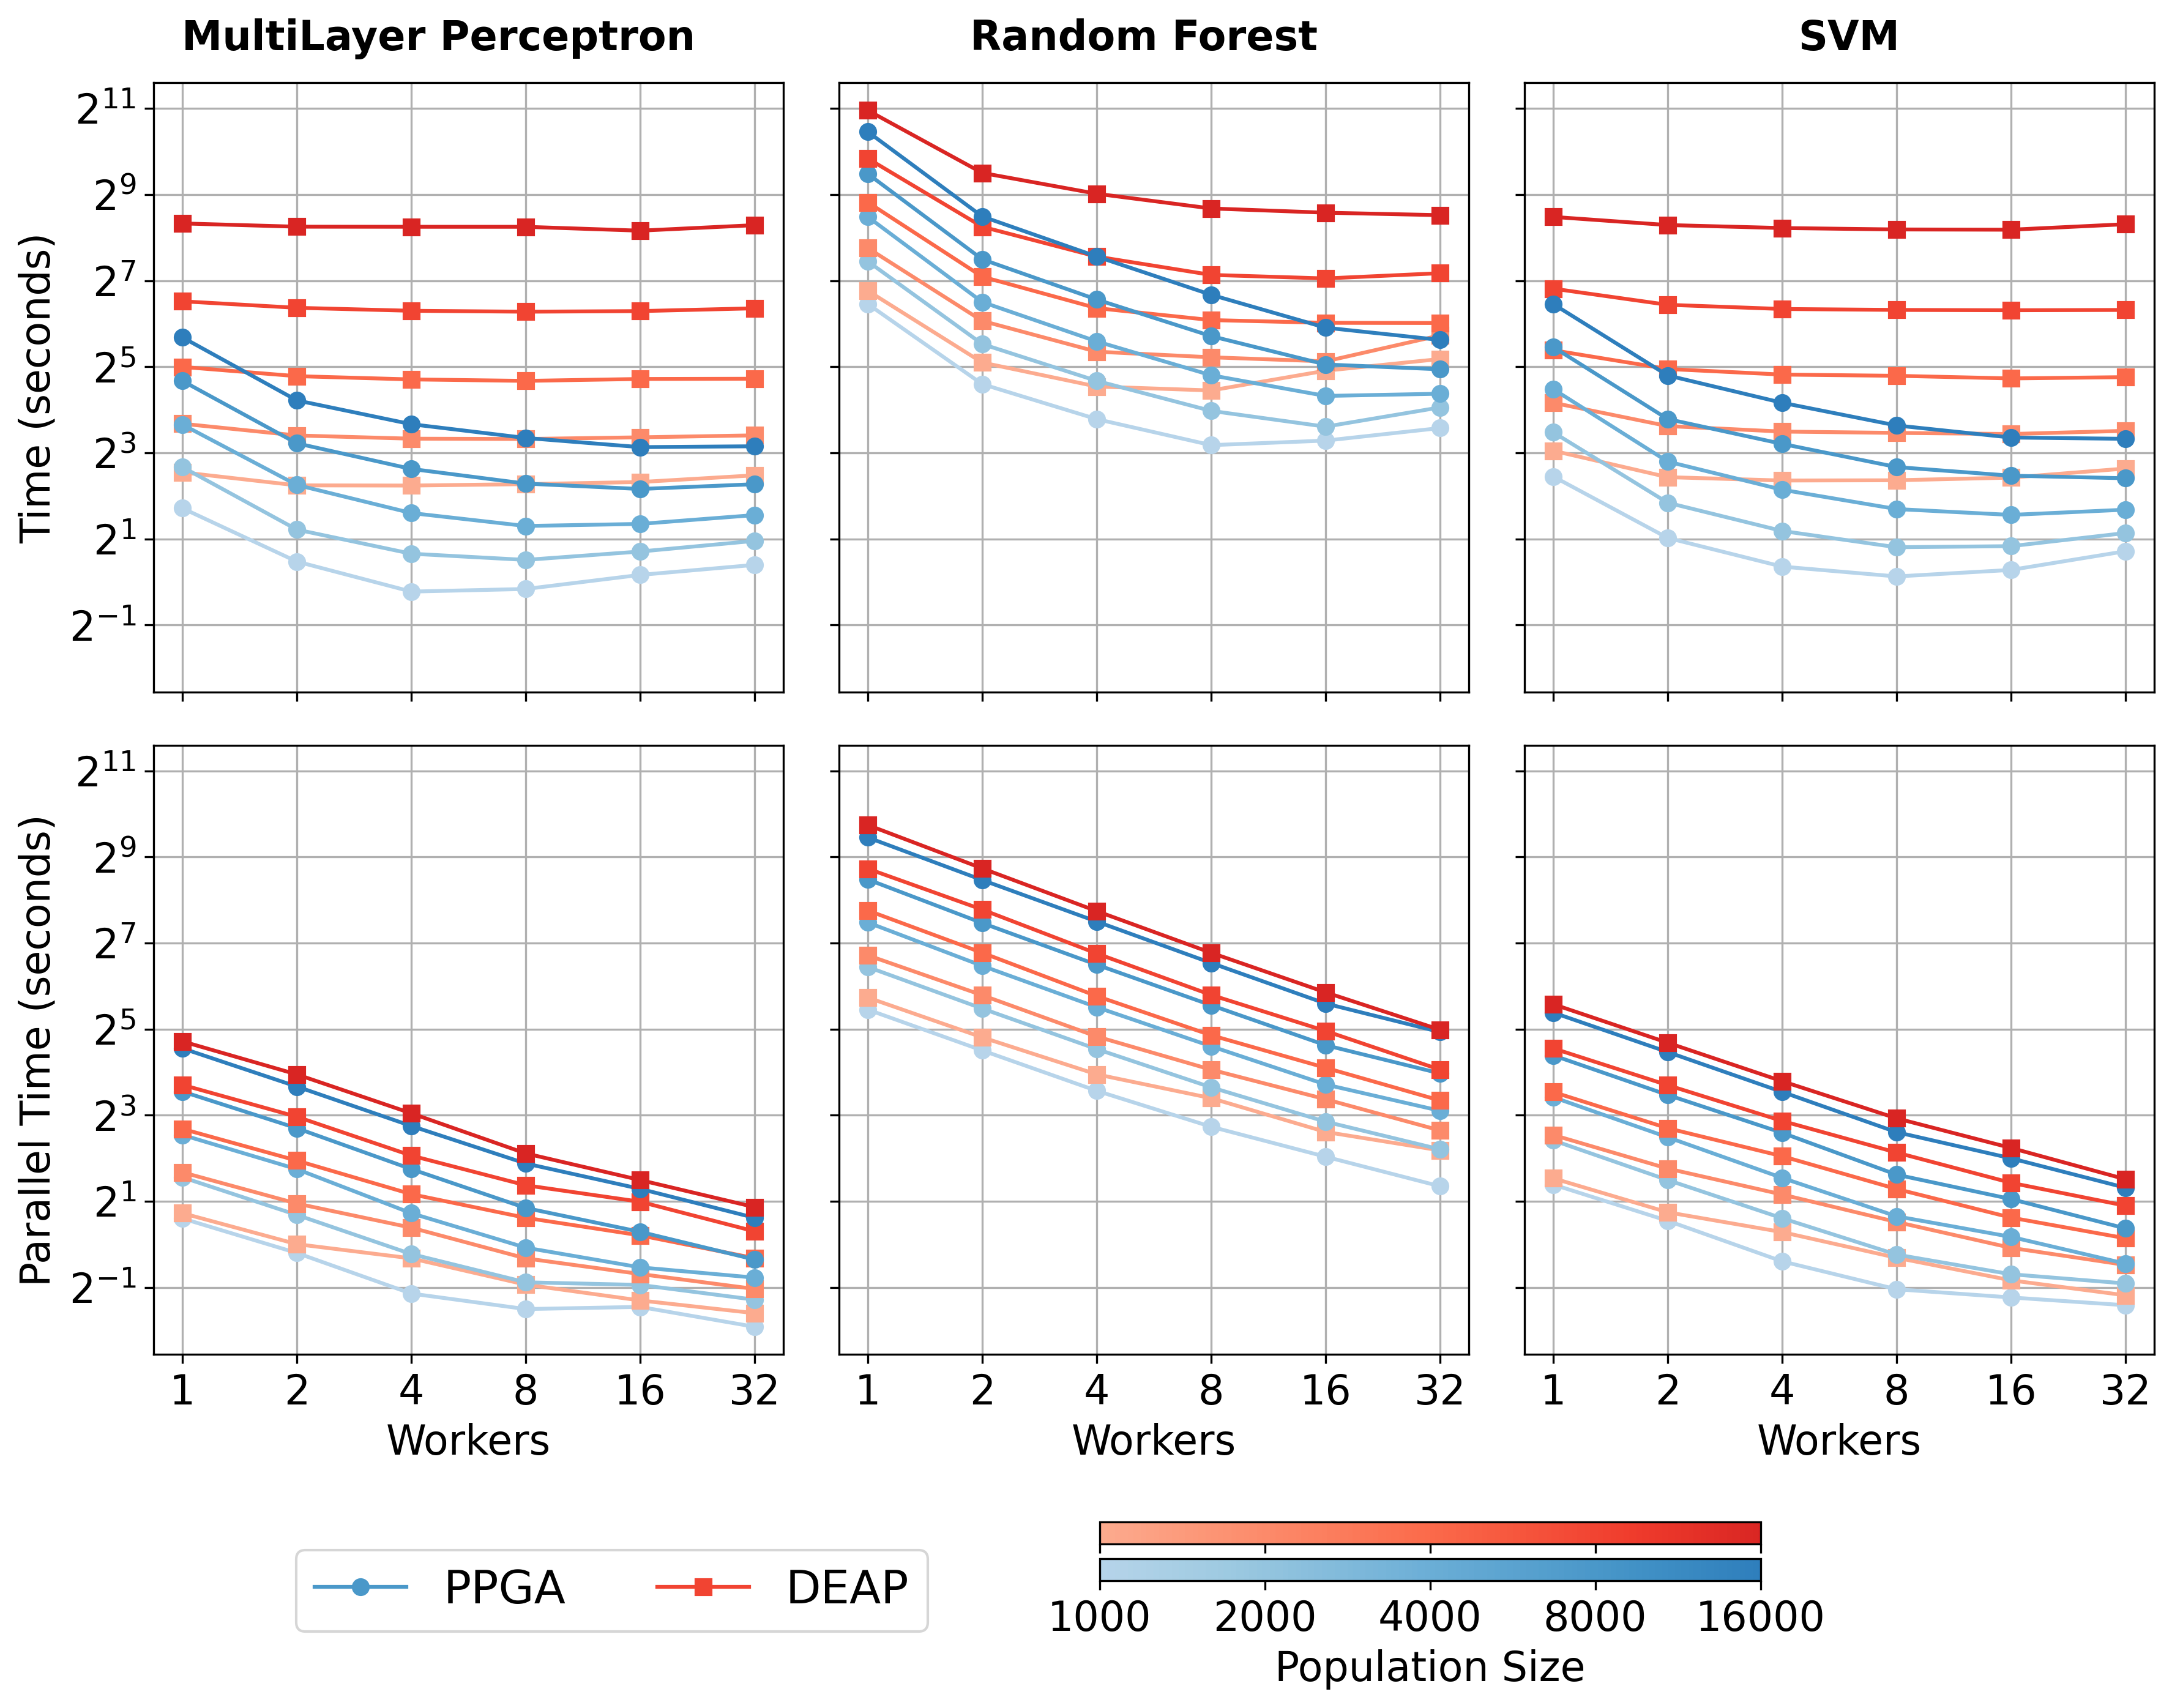

In [53]:
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors


def plot_time_diff(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    # workers = [1, 4, 16, 32]
    population_sizes = df["population_size"].unique()

    # fig, axes = plt.subplots(len(models), 2, figsize=(12, 12), dpi=300)
    fig, axes = plt.subplots(
        2, len(models), sharex=True, sharey=True, figsize=(12, 8), dpi=300
    )
    fig.subplots_adjust(bottom=0.5)
    blues = plt.cm.Blues(np.linspace(0.3, 0.7, len(population_sizes)))
    reds = plt.cm.Reds(np.linspace(0.3, 0.7, len(population_sizes)))

    col_titles = ["MultiLayer Perceptron", "Random Forest", "SVM"]
    for j, title in enumerate(col_titles):
        fig.text(
            0.2 + j * 0.32,
            1,
            title,
            ha="center",
            va="center",
            fontsize="16",
            fontweight="bold",
        )

    for i, model in enumerate(models):
        for j, ps in enumerate(population_sizes):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[0][i].plot(
                workers,
                df[mask]["ppga"].values,
                color=blues[j],
                marker="o",
            )
            axes[0][i].plot(
                workers,
                df[mask]["deap"].values,
                color=reds[j],
                marker="s",
            )
            # axes[0][i].set_xlabel("Population Size (1e+03)")
            if i == 0:
                axes[0][i].set_ylabel("Time (seconds)")
            axes[0][i].set_xscale("log", base=2)
            axes[0][i].set_yscale("log", base=2)
            axes[0][i].set_xticks(workers, labels=workers)
            # fig.text(0.34 + i * 0.34, 0.15, "1e3", fontsize="12")
            axes[0][i].grid(True)

            axes[1][i].plot(
                workers,
                df[mask]["p_ppga"].values,
                color=blues[j],
                marker="o",
            )
            axes[1][i].plot(
                workers,
                df[mask]["p_deap"].values,
                color=reds[j],
                marker="s",
            )
            axes[1][i].set_xlabel("Workers")
            if i == 0:
                axes[1][i].set_ylabel("Parallel Time (seconds)")
            axes[1][i].set_xscale("log", base=2)
            axes[1][i].set_yscale("log", base=2)
            axes[1][i].set_xticks(workers, labels=workers)
            # fig.text(0.34 + i * 0.34, 0.15, "1e3", fontsize="12")
            axes[1][i].grid(True)

    custom_legend = [
        Line2D([0], [0], color=blues[3], marker="o", label="PPGA"),
        Line2D([0], [0], color=reds[3], marker="s", label="DEAP"),
    ]
    fig.legend(
        handles=custom_legend,
        loc="lower left",
        bbox_to_anchor=(0.125, -0.1),
        ncol=3,
        fontsize=18,
    )

    cmap = plt.cm.Reds
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_Reds", cmap(np.linspace(0.3, 0.7, 256))
    )
    norm = mcolors.Normalize(0.3, 0.7)
    cbar_ax = fig.add_axes([0.5, -0.025, 0.3, 0.015])  # [x, y, larghezza, altezza]
    cb = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax,
        orientation="horizontal",
    )
    cb.set_ticks(np.linspace(0.3, 0.7, 5))
    cb.set_ticklabels([])

    cmap = plt.cm.Blues
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_Blues", cmap(np.linspace(0.3, 0.7, 256))
    )
    cbar_ax = fig.add_axes([0.5, -0.05, 0.3, 0.015])  # [x, y, larghezza, altezza]
    cb = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax,
        orientation="horizontal",
    )
    cb.set_ticks(np.linspace(0.3, 0.7, 5))
    cb.set_ticklabels([1000, 2000, 4000, 8000, 16000])
    cb.set_label("Population Size")

    fig.tight_layout()
    fig.savefig("/home/federico/tesi/immagini/time_pop.svg", bbox_inches="tight")
    fig.show()


plot_time_diff(time_cmp)

/tmp/ipykernel_7897/2817256904.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


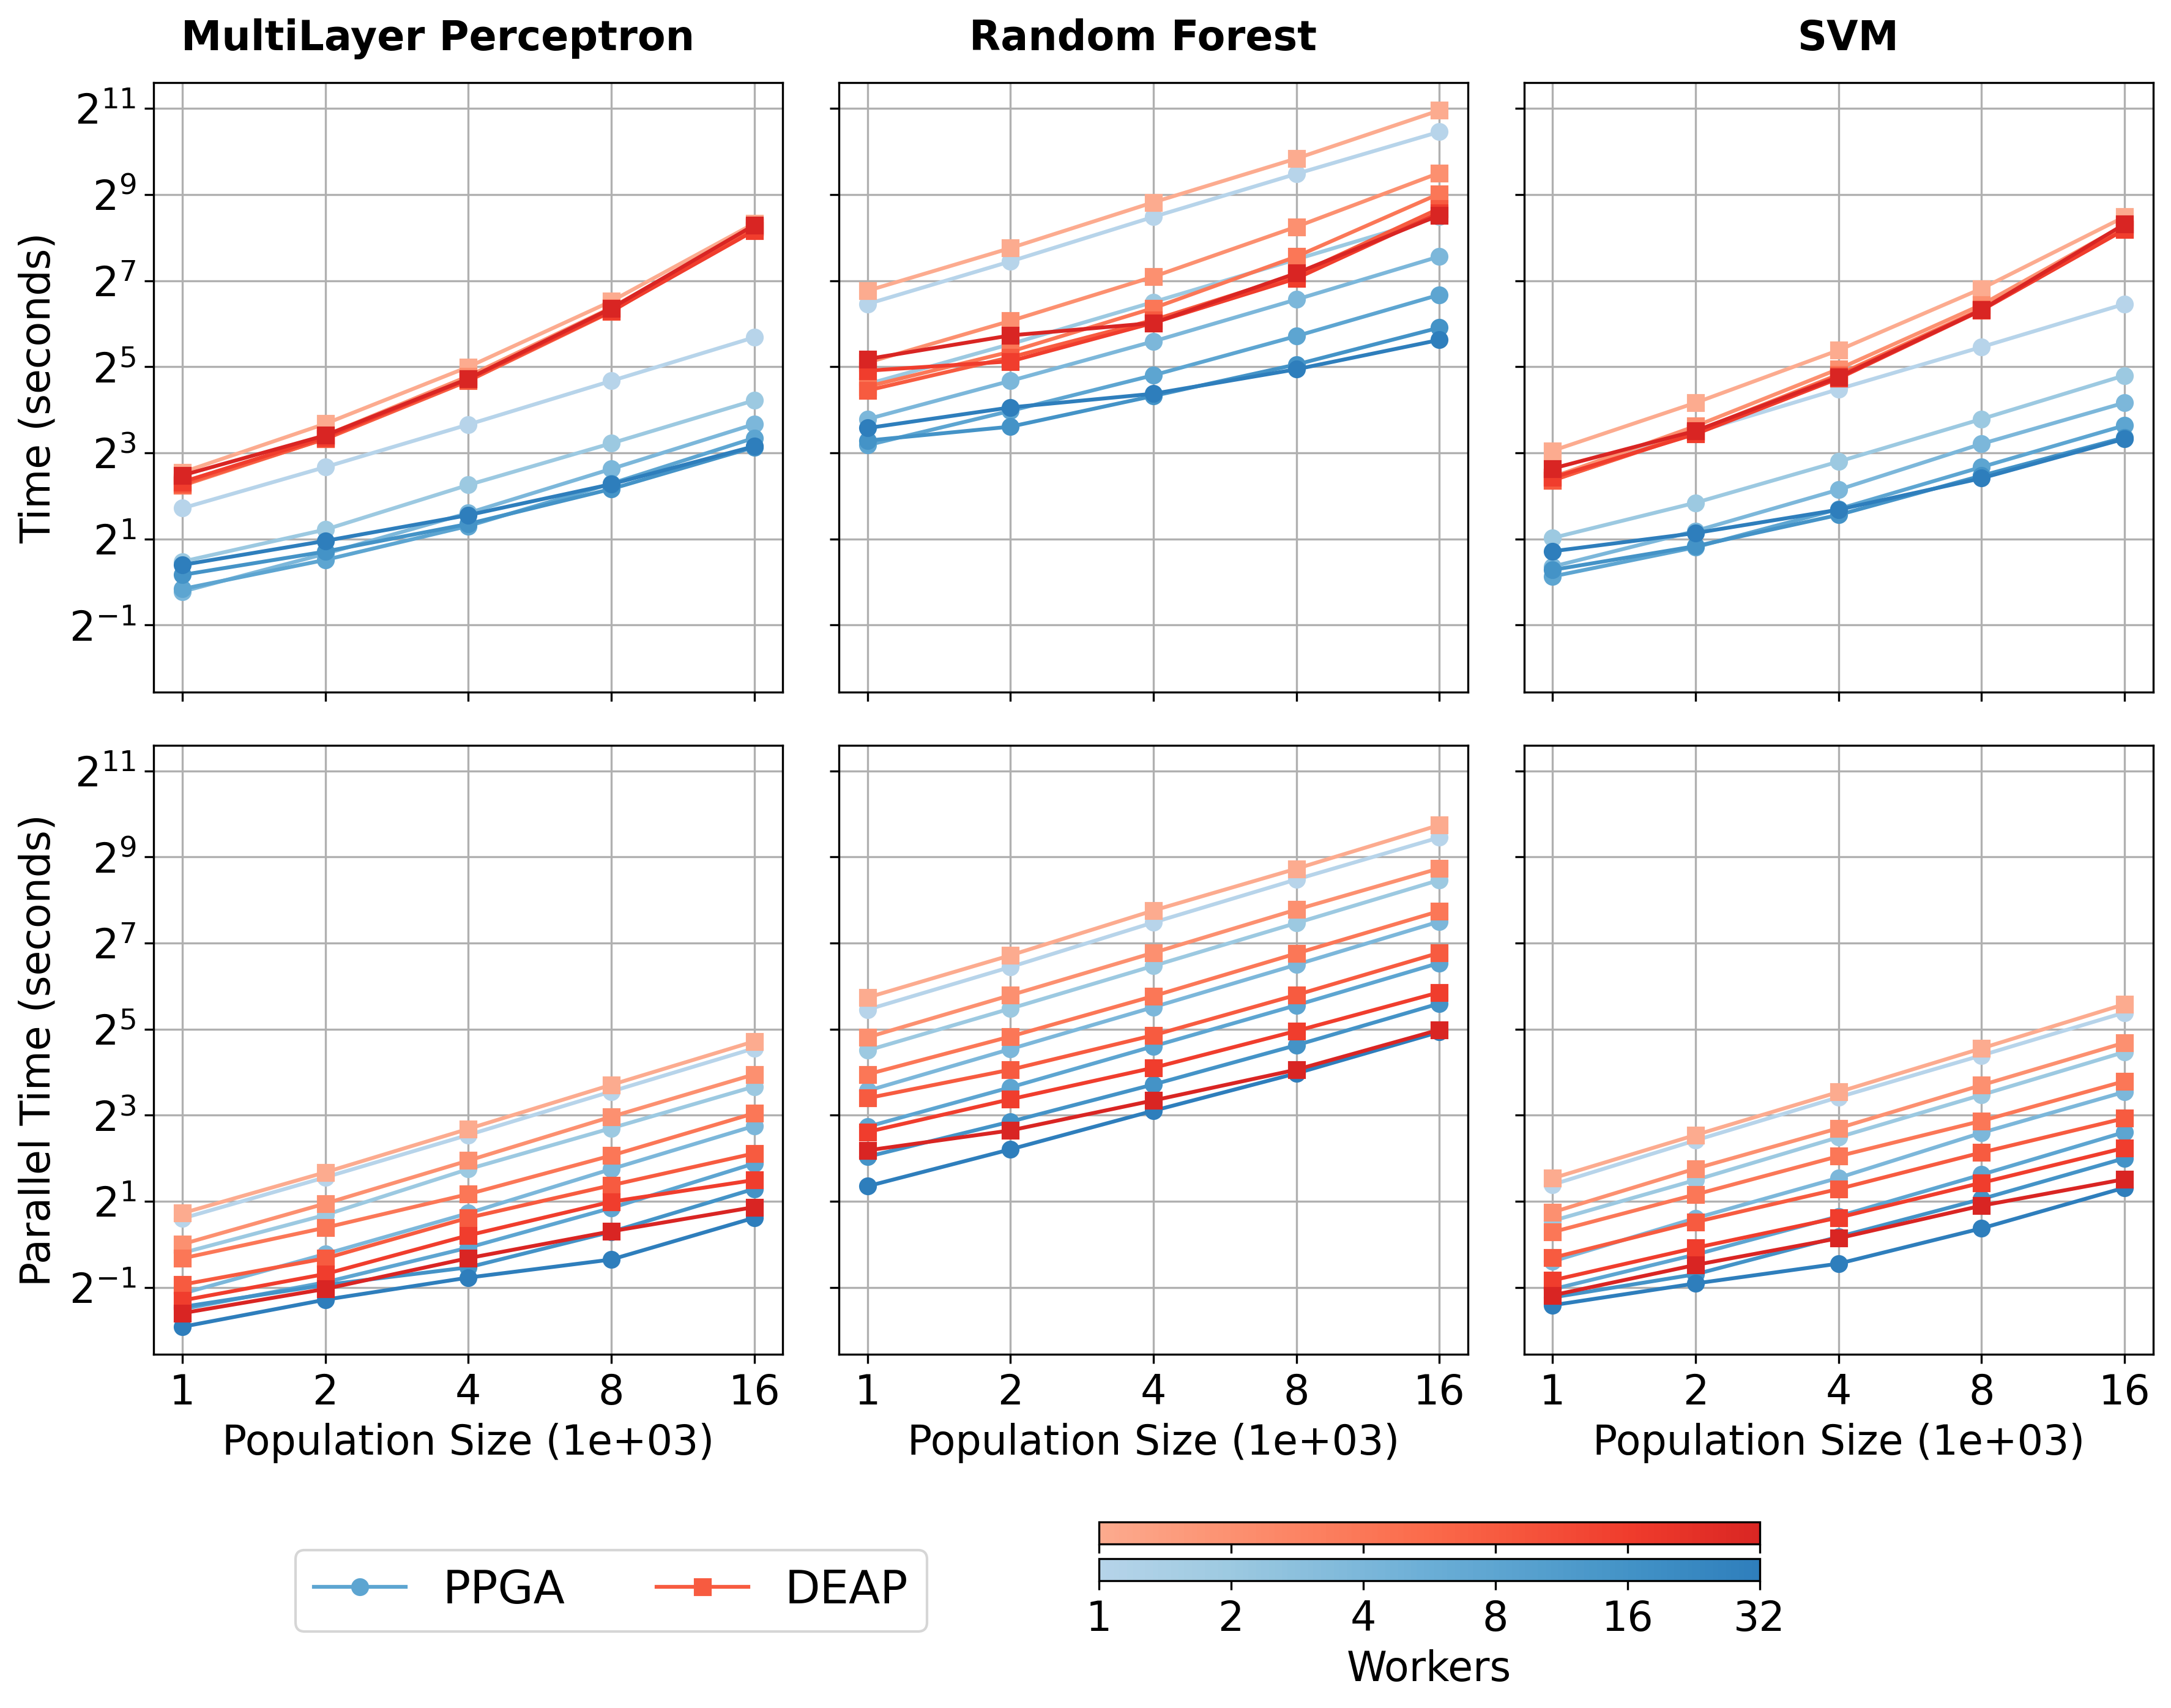

In [54]:
def plot_time_diff2(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    # workers = [1, 2, 4, 8, 32]
    population_sizes = df["population_size"].unique()

    # fig, axes = plt.subplots(len(models), 2, figsize=(12, 12), dpi=300)
    fig, axes = plt.subplots(
        2, len(models), sharex=True, sharey=True, figsize=(12, 8), dpi=300
    )
    blues = plt.cm.Blues(np.linspace(0.3, 0.7, len(workers)))
    reds = plt.cm.Reds(np.linspace(0.3, 0.7, len(workers)))

    col_titles = ["MultiLayer Perceptron", "Random Forest", "SVM"]
    for j, title in enumerate(col_titles):
        fig.text(
            0.2 + j * 0.32,
            1,
            title,
            ha="center",
            va="center",
            fontsize="16",
            fontweight="bold",
        )

    for i, model in enumerate(models):
        for j, w in enumerate(workers):
            mask = (df["classifier"] == model) & (df["workers"] == w)
            axes[0][i].plot(
                population_sizes,
                df[mask]["ppga"].values,
                color=blues[j],
                marker="o",
            )
            axes[0][i].plot(
                population_sizes,
                df[mask]["deap"].values,
                color=reds[j],
                marker="s",
            )
            # axes[0][i].set_xlabel("Population Size (1e+03)")
            if i == 0:
                axes[0][i].set_ylabel("Time (seconds)")
            axes[0][i].set_xscale("log", base=2)
            axes[0][i].set_yscale("log", base=2)
            axes[0][i].set_xticks(
                population_sizes, labels=[int(i) for i in population_sizes / 1000]
            )
            # fig.text(0.34 + i * 0.34, 0.15, "1e3", fontsize="12")
            axes[0][i].grid(True)

            # Partial
            axes[1][i].plot(
                population_sizes,
                df[mask]["p_ppga"].values,
                color=blues[j],
                marker="o",
            )
            axes[1][i].plot(
                population_sizes,
                df[mask]["p_deap"].values,
                color=reds[j],
                marker="s",
            )
            axes[1][i].set_xlabel("Population Size (1e+03)")
            if i == 0:
                axes[1][i].set_ylabel("Parallel Time (seconds)")
            axes[1][i].set_xscale("log", base=2)
            axes[1][i].set_yscale("log", base=2)
            axes[1][i].set_xticks(
                population_sizes, labels=[int(i) for i in population_sizes / 1000]
            )
            # fig.text(0.34 + i * 0.34, 0.15, "1e3", fontsize="12")
            axes[1][i].grid(True)

    custom_legend = [
        Line2D([0], [0], color=blues[3], marker="o", label="PPGA"),
        Line2D([0], [0], color=reds[3], marker="s", label="DEAP"),
    ]
    fig.legend(
        handles=custom_legend,
        loc="lower left",
        bbox_to_anchor=(0.125, -0.1),
        ncol=3,
        fontsize=18,
    )

    cmap = plt.cm.Reds
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_Reds", cmap(np.linspace(0.3, 0.7, 256))
    )
    norm = mcolors.Normalize(0.3, 0.7)
    cbar_ax = fig.add_axes([0.5, -0.025, 0.3, 0.015])  # [x, y, larghezza, altezza]
    cb = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax,
        orientation="horizontal",
    )
    cb.set_ticks(np.linspace(0.3, 0.7, 6))
    cb.set_ticklabels([])

    cmap = plt.cm.Blues
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_Blues", cmap(np.linspace(0.3, 0.7, 256))
    )
    cbar_ax = fig.add_axes([0.5, -0.05, 0.3, 0.015])  # [x, y, larghezza, altezza]
    cb = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax,
        orientation="horizontal",
    )
    cb.set_ticks(np.linspace(0.3, 0.7, 6))
    cb.set_ticklabels([1, 2, 4, 8, 16, 32])
    cb.set_label("Workers")

    fig.tight_layout()
    fig.savefig("/home/federico/tesi/immagini/time_pop2.svg", bbox_inches="tight")
    plt.show()


plot_time_diff2(time_cmp)

Di seguito un confronto tra il numero di volte in cui PPGA ha offerto
performance migliori rispetto a DEAP.


In [17]:
for model in ppga_df["classifier"].unique():
    mask = (time_cmp["classifier"] == model) & (time_cmp["p_ppga"] < time_cmp["p_deap"])
    ppga_better_time = (time_cmp[mask]).copy()
    print(
        f"{model} ppga better than deap {len(ppga_better_time) / len(time_cmp[time_cmp['classifier'] == model]) * 100.0:.2f}% of the times"
    )
    improvement = (
        (ppga_better_time["p_deap"] - ppga_better_time["p_ppga"])
        / ppga_better_time["p_deap"]
        * 100.0
    )
    print(f"{model} mean improvement: {improvement.mean():.2f}%")

MLPClassifier ppga better than deap 100.00% of the times
MLPClassifier mean improvement: 21.56%
RandomForestClassifier ppga better than deap 100.00% of the times
RandomForestClassifier mean improvement: 19.91%
SVC ppga better than deap 100.00% of the times
SVC mean improvement: 22.02%


La stessa analisi è stata ripetuta ma considerando solo i casi in cui DEAP ha
fornito le performance migliori.


In [18]:
deap_better_time = time_cmp[time_cmp["deap"] <= time_cmp["ppga"]]
print(
    f"deap better than ppga {len(deap_better_time) / len(time_cmp) * 100.0:.2f}% of the times"
)

improvement = (
    (deap_better_time["ppga"] - deap_better_time["deap"])
    / deap_better_time["ppga"]
    * 100.0
)
print(f"min improvement: {improvement.min():.2f}%")
print(f"mean improvement: {improvement.mean():.2f}%")
print(f"max improvement: {improvement.max():.2f}%")

deap better than ppga 0.00% of the times
min improvement: nan%
mean improvement: nan%
max improvement: nan%


## Speed up

Il secondo parametro di confronto è lo speed up. Dato che si vogliono mettere a
confronto le capacità di sfruttare al meglio l'architettura multicore della CPU,
in questo caso si sono considerati i soli valori di speed up nella fase
parallelizzata.


In [19]:
speedup_cmp = pd.DataFrame(
    {
        "classifier": ppga_df["classifier"].values,
        "population_size": ppga_df["population_size"].values,
        "workers": ppga_df["workers"].values,
        "ppga": ppga_df["speed_up"].values,
        "deap": deap_df["speed_up"].values,
        "p_ppga": ppga_df["pure_speed_up"].values,
        "p_deap": deap_df["pure_speed_up"].values,
    }
)

# speedup_cmp = speedup_cmp[speedup_cmp["workers"] != 1]
speedup_cmp

classifier  population_size  workers      ppga      deap     p_ppga  \
0   MLPClassifier             1000        1  1.000000  1.000000   1.000000   
1   MLPClassifier             1000        2  2.359960  1.232837   1.743287   
2   MLPClassifier             1000        4  3.827547  1.236940   3.351734   
3   MLPClassifier             1000        8  3.670291  1.208642   4.302580   
4   MLPClassifier             1000       16  2.925789  1.168545   4.155232   
..            ...              ...      ...       ...       ...        ...   
85            SVC            16000        2  3.156276  1.139958   1.887514   
86            SVC            16000        4  4.899591  1.196290   3.585992   
87            SVC            16000        8  7.063715  1.223831   6.855226   
88            SVC            16000       16  8.575913  1.229007  10.441565   
89            SVC            16000       32  8.755337  1.124924  16.769467   

       p_deap  
0    1.000000  
1    1.646555  
2    2.069807  
3    3.159179  
4    4.075731  
..        ...  
85   1.858804  
86   3.453026  
87   6.276061  
88  10.112171  
89  16.732497  

[90 rows x 7 columns]

In [56]:
mask = (speedup_cmp["population_size"] == 2000) | (
    speedup_cmp["population_size"] == 16000
)
mask = mask & (speedup_cmp["workers"] == 32)
print(
    speedup_cmp[mask][["classifier", "population_size", "p_ppga", "p_deap"]]
    .rename(
        columns={
            "classifier": "Modello",
            "population_size": "Popolazione",
            "p_ppga": "PPGA",
            "p_deap": "DEAP",
        }
    )
    .to_latex(index=False, float_format="%.3f")
)
speedup_cmp[mask]

\begin{tabular}{lrrr}
\toprule
Modello & Popolazione & PPGA & DEAP \\
\midrule
MLPClassifier & 2000 & 7.172 & 6.540 \\
MLPClassifier & 16000 & 15.312 & 14.422 \\
RandomForestClassifier & 2000 & 18.832 & 16.771 \\
RandomForestClassifier & 16000 & 22.931 & 27.016 \\
SVC & 2000 & 10.012 & 8.104 \\
SVC & 16000 & 16.769 & 16.732 \\
\bottomrule
\end{tabular}



classifier  population_size  workers       ppga      deap  \
11           MLPClassifier             2000       32   3.281713  1.205528   
29           MLPClassifier            16000       32   5.775306  1.028179   
41  RandomForestClassifier             2000       32  10.497658  4.081717   
59  RandomForestClassifier            16000       32  28.516713  5.400995   
71                     SVC             2000       32   5.058866  1.570779   
89                     SVC            16000       32   8.755337  1.124924   

       p_ppga     p_deap  
11   7.171531   6.539946  
29  15.312240  14.422245  
41  18.832248  16.770775  
59  22.930692  27.015644  
71  10.011806   8.103872  
89  16.769467  16.732497

/tmp/ipykernel_7897/592973628.py:121: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.set_ticklabels([1000, 2000, 4000, 8000, 16000])
/tmp/ipykernel_7897/592973628.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


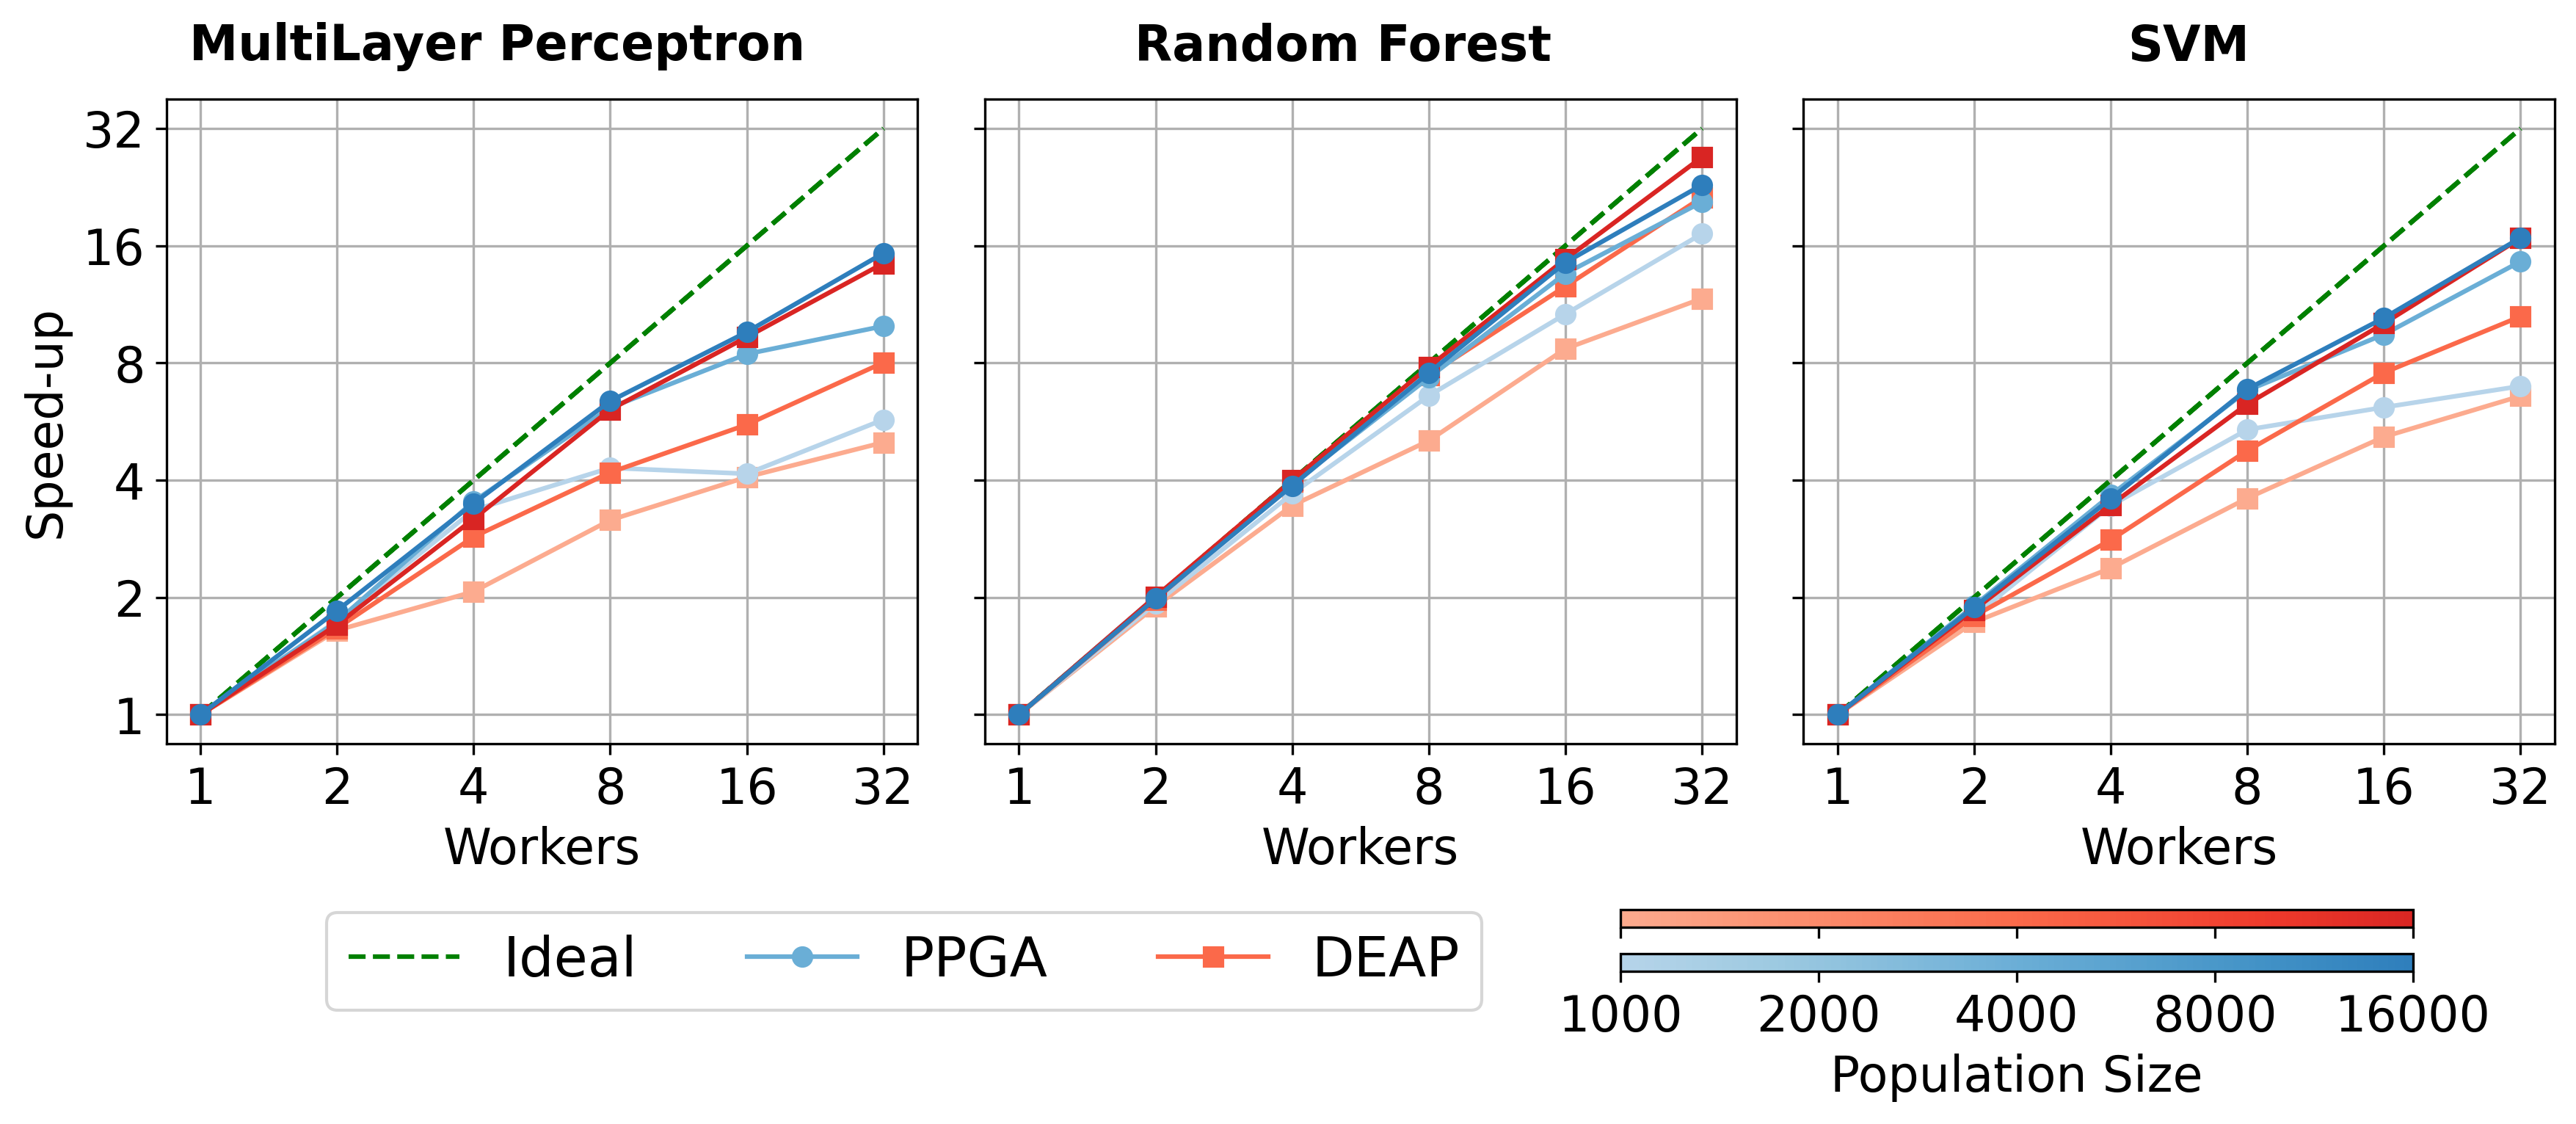

In [21]:
def plot_speedup_diff(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()
    population_sizes = [1000, 4000, 16000]

    fig, axes = plt.subplots(1, len(models), sharey=True, figsize=(12, 4), dpi=300)
    blues = plt.cm.Blues(np.linspace(0.3, 0.7, len(population_sizes)))
    reds = plt.cm.Reds(np.linspace(0.3, 0.7, len(population_sizes)))

    col_titles = ["MultiLayer Perceptron", "Random Forest", "SVM"]
    for j, title in enumerate(col_titles):
        fig.text(
            0.2 + j * 0.32,
            1,
            title,
            ha="center",
            va="center",
            fontsize="16",
            fontweight="bold",
        )

    for i, model in enumerate(models):
        # fig.text(
        #     1.005,
        #     0.85 - i * 0.33,
        #     ["MultiLayer Perceptron", "Random Forest", "SVM"][i],
        #     ha="center",
        #     va="center",
        #     fontsize=16,
        #     fontweight="bold",
        #     rotation=90,
        # )
        for j, ps in enumerate(population_sizes):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            # axes[i].plot(
            #     workers,
            #     df[mask]["deap"].values,
            #     color=reds[j],
            #     marker="s",
            #     label=f"DEAP {ps}",
            # )
            # axes[i].plot(
            #     workers,
            #     df[mask]["ppga"].values,
            #     color=blues[j],
            #     marker="o",
            #     label=f"PPGA {ps}",
            # )
            # axes[i].set_xlabel("Workers")
            # axes[i].set_ylabel("Speed-up")
            # axes[i].set_xscale("log", base=2)
            # axes[i].set_yscale("log", base=2)
            # axes[i].set_xticks(workers, labels=workers)
            # axes[i].set_yticks(workers, labels=workers)
            # axes[i].grid()

            # Partial
            # axes[i].set_box_aspect(3 / 4)
            axes[i].plot(workers, workers, "g--")
            axes[i].plot(
                workers,
                df[mask]["p_deap"].values,
                color=reds[j],
                marker="s",
                label=f"DEAP {ps}",
            )
            axes[i].plot(
                workers,
                df[mask]["p_ppga"].values,
                color=blues[j],
                marker="o",
                label=f"PPGA {ps}",
            )
            axes[i].set_xlabel("Workers")
            axes[i].set_xscale("log", base=2)
            axes[i].set_yscale("log", base=2)
            if i == 0:
                axes[i].set_ylabel("Speed-up")
            axes[i].set_xticks(workers, labels=workers)
            axes[i].set_yticks(workers, labels=workers)
            axes[i].grid()

    custom_legend = [
        Line2D([0], [0], color="g", linestyle="dashed", label="Ideal"),
        Line2D([0], [0], color=blues[1], marker="o", label="PPGA"),
        Line2D([0], [0], color=reds[1], marker="s", label="DEAP"),
    ]
    fig.legend(
        handles=custom_legend,
        loc="lower left",
        bbox_to_anchor=(0.125, -0.125),
        ncol=3,
        fontsize=18,
    )

    cmap = plt.cm.Reds
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_Reds", cmap(np.linspace(0.3, 0.7, 256))
    )
    norm = mcolors.Normalize(0.3, 0.7)
    cbar_ax = fig.add_axes([0.625, 0.0, 0.3, 0.02])  # [x, y, larghezza, altezza]
    cb = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax,
        orientation="horizontal",
    )
    cb.set_ticklabels([])

    cmap = plt.cm.Blues
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_Blues", cmap(np.linspace(0.3, 0.7, 256))
    )
    cbar_ax = fig.add_axes([0.625, -0.05, 0.3, 0.02])  # [x, y, larghezza, altezza]
    cb = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax,
        orientation="horizontal",
    )
    # cb.set_ticks([1000, 2000, 4000, 8000, 16000])
    cb.set_ticklabels([1000, 2000, 4000, 8000, 16000])
    cb.set_label("Population Size")

    fig.tight_layout()
    fig.savefig("/home/federico/tesi/immagini/speedup_pop.svg", bbox_inches="tight")
    plt.show()


plot_speedup_diff(speedup_cmp)

Anche in questo caso PPGA sembra fornire valori di speed up migliori e più in
linea con il numero di worker impiegati. DEAP sembra invece non riuscire a
sfruttare a pieno l'architettura multicore su carichi di lavoro più leggeri.


In [22]:
ppga_better_speedup = speedup_cmp[speedup_cmp["ppga"] > speedup_cmp["deap"]]
print(
    f"ppga better than deap {len(ppga_better_speedup) / len(speedup_cmp) * 100.0:.2f}% of the times"
)

deap_better_speedup = speedup_cmp[speedup_cmp["deap"] >= speedup_cmp["ppga"]]
print(
    f"deap better than ppga {len(deap_better_speedup) / len(speedup_cmp) * 100.0:.2f}% of the times"
)

ppga better than deap 83.33% of the times
deap better than ppga 16.67% of the times


## Efficienza

Confrontare il tempo d'esecuzione può essere un buon indice per paragonare le
performance dei due algoritmi, quando però andiamo a paragonare i valori di
speed up non otteniamo una vera e propria misura di quanto un modello di calcolo
parallelo sia migliore rispetto ad un altro. Questo è anche dovuto al fatto
che il tempo d'esecuzione, a parità di worker impiegati, potrebbe variare.
Diventa quindi necessario ricavare una misura che sia proporzionale al tempo
d'esecuzione. Di seguito viene calcolata l'efficienza del modello

$$e = \frac{s}{n}$$

dove $s$ è lo speed up ottenuto e $n$ il numero di worker impiegati dai due
algoritmi nella solo fase parallelizzata. Questo indice dovrebbe favorire
l'algoritmo più veloce e che allo stesso tempo offre valori di speed up più
elevati.


In [23]:
efficiency_cmp = pd.DataFrame(
    {
        "classifier": ppga_df["classifier"].values,
        "population_size": ppga_df["population_size"].values,
        "workers": ppga_df["workers"].values,
        "ppga": ppga_df["pure_speed_up"] / ppga_df["workers"],
        "deap": deap_df["pure_speed_up"] / deap_df["workers"],
    }
)

efficiency_cmp = efficiency_cmp[efficiency_cmp["workers"] != 1]
efficiency_cmp

classifier  population_size  workers      ppga      deap
1   MLPClassifier             1000        2  0.871643  0.823277
2   MLPClassifier             1000        4  0.837933  0.517452
3   MLPClassifier             1000        8  0.537823  0.394897
4   MLPClassifier             1000       16  0.259702  0.254733
5   MLPClassifier             1000       32  0.178851  0.156314
..            ...              ...      ...       ...       ...
85            SVC            16000        2  0.943757  0.929402
86            SVC            16000        4  0.896498  0.863256
87            SVC            16000        8  0.856903  0.784508
88            SVC            16000       16  0.652598  0.632011
89            SVC            16000       32  0.524046  0.522891

[75 rows x 5 columns]

In [59]:
ppga_better_eff = efficiency_cmp[efficiency_cmp["ppga"] > efficiency_cmp["deap"]]
print(
    f"ppga better than deap {len(ppga_better_eff) / len(efficiency_cmp) * 100.0:.2f}% of the times"
)

ppga better than deap 86.67% of the times


Dalla tabella e dai grafici riportati di seguito si può notare come PPGA
offra, nella maggior parte dei casi, un coefficiente migliore. Dobbiamo però
considerare anche l'andamento di tale coefficiente caso per caso. Se rimane
stabile o tende a crescere con il crescere del numero di worker, potrebbe
essere un buon indice per valutare la scalabilità dell'algoritmo su un numero
ancora più alto di worker.


/tmp/ipykernel_7897/3710782424.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.set_ticklabels([1000, 2000, 4000, 8000, 16000])
/tmp/ipykernel_7897/3710782424.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


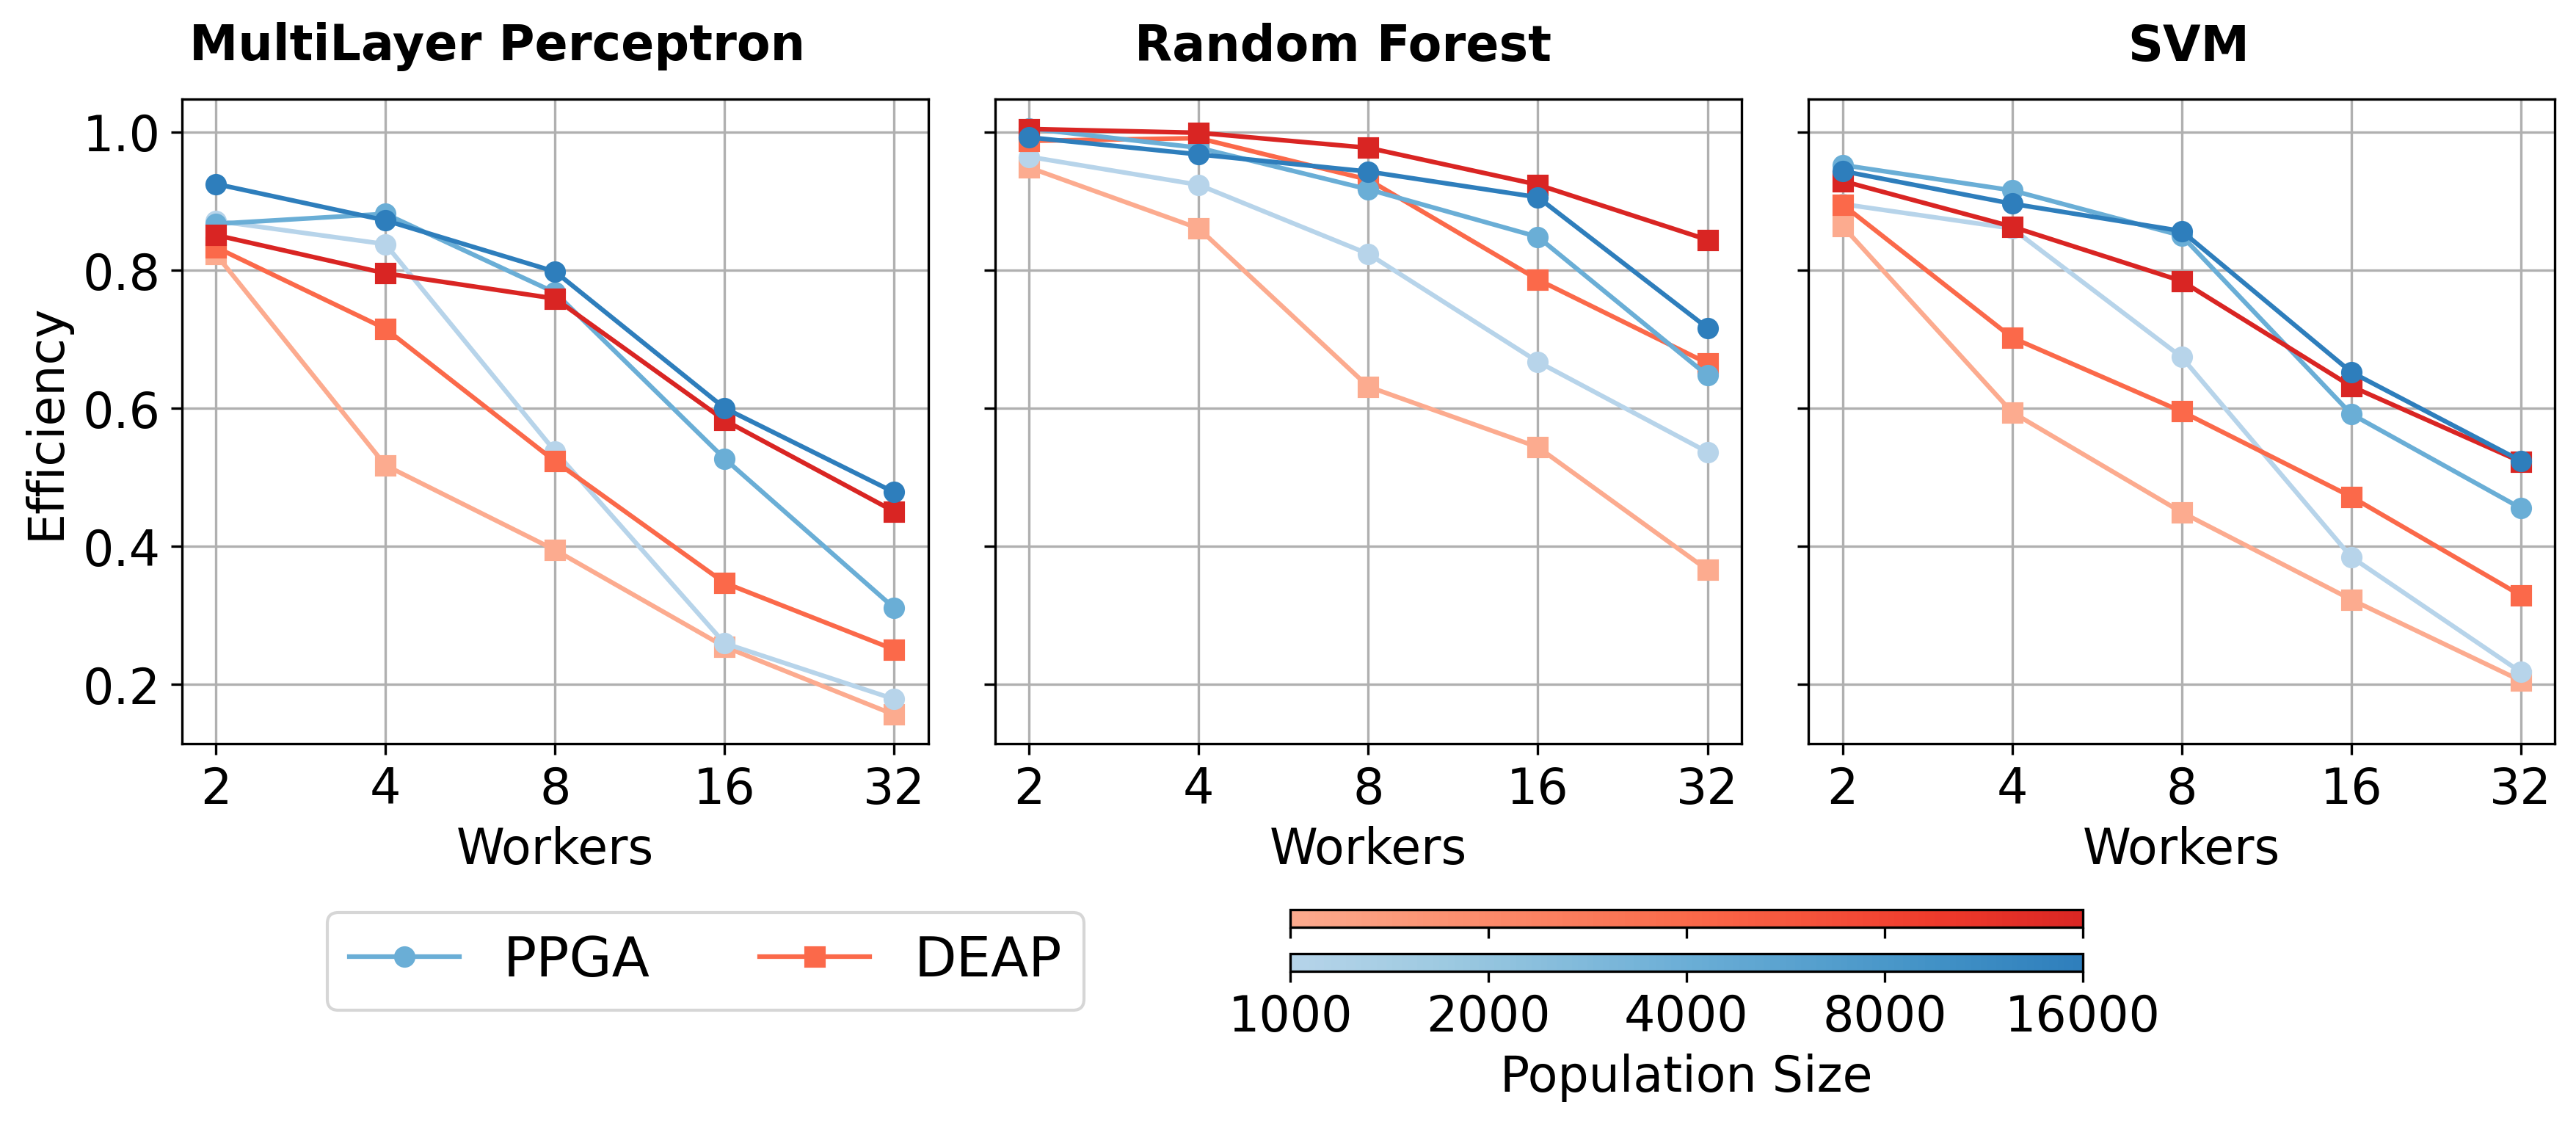

In [24]:
def plot_efficiency(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()
    population_sizes = [1000, 4000, 16000]

    fig, axes = plt.subplots(1, len(models), sharey=True, figsize=(12, 4), dpi=300)
    blues = plt.cm.Blues(np.linspace(0.3, 0.7, len(population_sizes)))
    reds = plt.cm.Reds(np.linspace(0.3, 0.7, len(population_sizes)))

    col_titles = ["MultiLayer Perceptron", "Random Forest", "SVM"]
    for j, title in enumerate(col_titles):
        fig.text(
            0.2 + j * 0.32,
            1,
            title,
            ha="center",
            va="center",
            fontsize="16",
            fontweight="bold",
        )

    for i, model in enumerate(models):
        for j, ps in enumerate(population_sizes):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i].plot(
                workers,
                df[mask]["deap"].values,
                color=reds[j],
                marker="s",
                label=f"DEAP {ps}",
            )
            axes[i].plot(
                workers,
                df[mask]["ppga"].values,
                color=blues[j],
                marker="o",
                label=f"PPGA {ps}",
            )
            axes[i].set_xlabel("Workers")
            if i == 0:
                axes[i].set_ylabel("Efficiency")
            axes[i].set_xscale("log", base=2)
            axes[i].set_xticks(workers, labels=workers)
            axes[i].grid()

    custom_legend = [
        Line2D([0], [0], color=blues[1], marker="o", label="PPGA"),
        Line2D([0], [0], color=reds[1], marker="s", label="DEAP"),
    ]
    fig.legend(
        handles=custom_legend,
        loc="lower left",
        bbox_to_anchor=(0.125, -0.125),
        ncol=3,
        fontsize=18,
    )

    cmap = plt.cm.Reds
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_Reds", cmap(np.linspace(0.3, 0.7, 256))
    )
    norm = mcolors.Normalize(0.3, 0.7)
    cbar_ax = fig.add_axes([0.5, 0.0, 0.3, 0.02])  # [x, y, larghezza, altezza]
    cb = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax,
        orientation="horizontal",
    )
    cb.set_ticklabels([])

    cmap = plt.cm.Blues
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_Blues", cmap(np.linspace(0.3, 0.7, 256))
    )
    cbar_ax = fig.add_axes([0.5, -0.05, 0.3, 0.02])  # [x, y, larghezza, altezza]
    cb = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax,
        orientation="horizontal",
    )
    # cb.set_ticks([1000, 2000, 4000, 8000, 16000])
    cb.set_ticklabels([1000, 2000, 4000, 8000, 16000])
    cb.set_label("Population Size")
    plt.tight_layout()
    plt.savefig("/home/federico/tesi/immagini/efficiency_pop.svg", bbox_inches="tight")
    plt.show()


plot_efficiency(efficiency_cmp)

In [25]:
mask = efficiency_cmp["population_size"] == 8000
mask = mask & (
    (efficiency_cmp["workers"] == 8)
    | (efficiency_cmp["workers"] == 16)
    | (efficiency_cmp["workers"] == 32)
)
print(
    efficiency_cmp[mask][["classifier", "workers", "ppga", "deap"]]
    .rename(
        columns={
            "classifier": "Modello",
            "workers": "Workers",
            "ppga": "PPGA",
            "deap": "DEAP",
        }
    )
    .to_latex(index=False, float_format="%.3f")
)
efficiency_cmp[mask][["classifier", "workers", "ppga", "deap"]]

\begin{tabular}{lrrr}
\toprule
Modello & Workers & PPGA & DEAP \\
\midrule
MLPClassifier & 8 & 0.815 & 0.630 \\
MLPClassifier & 16 & 0.598 & 0.410 \\
MLPClassifier & 32 & 0.468 & 0.330 \\
RandomForestClassifier & 8 & 0.947 & 0.954 \\
RandomForestClassifier & 16 & 0.901 & 0.852 \\
RandomForestClassifier & 32 & 0.709 & 0.795 \\
SVC & 8 & 0.853 & 0.669 \\
SVC & 16 & 0.632 & 0.544 \\
SVC & 32 & 0.506 & 0.393 \\
\bottomrule
\end{tabular}



classifier  workers      ppga      deap
21           MLPClassifier        8  0.815214  0.629579
22           MLPClassifier       16  0.598491  0.410337
23           MLPClassifier       32  0.467511  0.330433
51  RandomForestClassifier        8  0.947051  0.954137
52  RandomForestClassifier       16  0.901017  0.852023
53  RandomForestClassifier       32  0.709420  0.794804
81                     SVC        8  0.852714  0.668715
82                     SVC       16  0.631564  0.544224
83                     SVC       32  0.506351  0.393375

# Conclusioni

In quanto a tempo d'esecuzione PPGA prevale nella quasi totalità dei casi, con
un miglioramento medio di più del 50% e un miglioramento massimo di più del 95%
rispetto a DEAP.

Possiamo notare anche come PPGA impieghi gran parte del suo tempo nella
fase parallelizzata (almeno il 50%), comportando quindi un miglioramento più
marcato per l'intero algoritmo nel momento in cui si decida di sfruttare più
worker. Da notare invece che DEAP, all'aumentare della dimensione dell'input,
spende meno tempo in quella fase, non riuscendo infatti a trarre grandi
benefici da un architettura di calcolo parallela.

Anche sui valori di speed up PPGA prevale in più dell'80% dei test effettuati,
dimostrando inoltre di riuscire ad ottenere valori di speed up molto più alti
nonostante il tempo d'esecuzione sia generalmente inferiore rispetto a DEAP.

Per quanto riguarda l'ultima metrica, ossia il coefficiente di speed up, PPGA
ottiene punteggi migliori nella quasi totalità dei casi. Eccetto per il caso in
cui il modello utilizzato è un Random Forest, PPGA risulta avere valori del
coefficiente nettamente superiori, dimostrando di saper sfruttare meglio
l'architetture multicore rispetto a DEAP.

## Possibile strategia per explainability

Nel problema trattato, in cui si richiedono numerose esecuzioni dell'algoritmo
genetico, si potrebbe pensare di partizionare il dataset in $n$ parti e adibire
$k$ core a ciascuna partizione di modo da eseguire l'algoritmo genetico
parallelo su $n$ core e su $m$ punti contemporaneamente.

Sarà quindi necessaria un'analisi preliminare in cui si cerca di approssimare
il numero di worker più adatto ad una singola esecuzione dell'algoritmo
genetico. Il numero di partizioni del dataset sarà semplicemente calcolato come:

$$n = \frac{c_t}{w}$$

dove $c_t$ è il numero di core totali presenti sulla macchina o che si intende
utilizzare e $w$ è il numero di worker stimato al passo precedente. Questo può
essere utile quando si lavora con classificatori più performanti in fase di
predizione, con i quali sarebbe quindi inutile impiegare tutti i core della
macchina.
